# Binder Cumulants and the Scaling Hypothesis

In [1]:
using GLMakie
using CairoMakie
using OffsetArrays
using Random
using ProgressMeter
using Statistics
using DataStructures
using LinearAlgebra
using LaTeXStrings
using HDF5
using Polynomials
CairoMakie.activate!(type = "png")

In the last lecture we explored the "Free energy" -- which is the logarithm of the probability distribution, $P(m)$.  We argued that in the paramagnetic state the free energy had a minimum at $m=0$, while in the ferromagnet it has a minimum at $m\neq 0$.  Here we will use this property to find the phase transition point.

## Previous Results

In [2]:
mutable struct Sweepdata
    arraysize
    betas
    maglists
    Elists
end

function savesweep(data::Sweepdata,filename::String)
    h5open(filename,"w") do file
        write(file,"arraysize",[data.arraysize...])
        write(file,"betas",Float64[data.betas...])
        write(file,"maglists",hcat(data.maglists...))
        write(file,"Elists",hcat(data.Elists...))
    end
end

savesweep(filename::String,data::Sweepdata)=savesweep(data,filename)

function loadsweep(filename::String)
    datastream=h5open(filename, "r")
    arraysize=read(datastream["arraysize"])
    betas=read(datastream["betas"])
    maglists=read(datastream["maglists"])
    Elists=read(datastream["Elists"])
    return Sweepdata(
        Tuple(arraysize),
        betas,
        [m[:] for m in eachcol(maglists)],
        [e[:] for e in eachcol(Elists)])
end

function tempsweep(m,n,initialbeta,finalbeta,betastep,burnsweeps,outersweeps)
    s=rand_ising2d(m,n)
    β=initialbeta
    arraysize=(m,n)
    energylists=[]
    maglists=[]
    betalist=[]
    while β*betastep<=finalbeta*betastep  #multiply be betastep so get right condition when betastep is negative
        run=fullsimulate!(s,β,0.,burnsweeps,outersweeps)
        push!(energylists,run.Elist)
        push!(maglists,run.maglist)
        push!(betalist,β)
        β+=betastep
    end
    return Sweepdata(arraysize,betalist,maglists,energylists)
end 

function stats(timeseries)
    m=mean(timeseries)
    len=length(timeseries)
    numbins=10
    binlength=floor(Int64,len/numbins)
    bins=[sum(timeseries[j+1:j+binlength])/binlength for j in 0:binlength:(numbins-1)*binlength]
    err=sqrt((bins⋅bins-numbins*m^2)/numbins^2)
    return m,err
end

stats(obj,key::Symbol,transform)=
    [stats(transform(ser)) for ser in getfield(obj,key)]

@inline function pushneighbors!(neighbors,ind,sz)
    i=ind[1]
    j=ind[2]
    (m,n)=sz
    τ₁=CartesianIndex(mod1(i-1,m),j)
    τ₂=CartesianIndex(mod1(i+1,m),j)
    τ₃=CartesianIndex(i,mod1(j-1,n))
    τ₄=CartesianIndex(i,mod1(j+1,n))
    push!(neighbors,τ₁)
    push!(neighbors,τ₂)
    push!(neighbors,τ₃)
    push!(neighbors,τ₄)
end

function wolfupdate!(s,pbar #=exp(-2beta)=#,numclusters)
    m, n = sz = size(s)
    numflipped=0
    neighbors=CartesianIndex{2}[]
    loc=rand(CartesianIndices(sz))
    for sweep in 1:numclusters
        loc=rand(CartesianIndices(sz))
        σ=s[loc]
        s[loc]=-σ
        numflipped+=1
        pushneighbors!(neighbors,loc,sz)
        while length(neighbors)>0
            nb=pop!(neighbors)
            if s[nb]!=σ 
                continue
            end
            if rand()<pbar
                continue
            end
            s[nb]=-σ
            numflipped+=1
            pushneighbors!(neighbors,nb,sz)
        end
    end
    return numflipped
end 

function wolfsimulate(m::Int64,n::Int64,β::Float64,h::Float64,
        innersweeps::Int64,outersweeps::Int64)
    s=rand_ising2d(m,n)
    wolfsimulate!(s,β,h,innersweeps,outersweeps)
end

function wolfsimulate!(s,β::Float64,h::Float64,
        innersweeps::Int64,outersweeps::Int64)
    # First generate the probability distribution

    pbar=exp(-2*β)
    
    # Create empty lists for storing the energies and magnetizations

    Elist=Float64[]
    maglist=Float64[]
    fliplist=Float64[]

    # next do the outer loop
    for outer in 1:outersweeps
        # 
        f=wolfupdate!(s,pbar,innersweeps)
        E=Energy(s,h)
        mag=Magnetization(s)
        push!(Elist,E)
        push!(maglist,mag)
        push!(fliplist,f)
        # call randlocalupdate!
        # then calcualte/store E and m in the lists

    end

    return (Elist=Elist ,maglist=maglist, 
        fliplist=fliplist,dims=size(s) ,β=β ,h=0 ,innersweeps=innersweeps)
end

function Energy(s #=spin configuration=#,h)
    m, n = size(s)
    E=0.
    @inbounds for i in 1:m
        @inbounds for j in 1:n
            E+=-s[i,j]*(h+s[mod1(i+1,m),j]+s[i,mod1(j+1,n)])
        end
    end
    return E/(m*n)
end

Magnetization(s#=spin configuration=#)=mean(s)

rand_ising2d(m=128, n=m) = rand(Int8[-1, 1], m, n)

function fullsimulate!(
        s,β::Float64,h::Float64,
        burnsweeps::Int64,outersweeps::Int64)
    m,n=size(s)
    # do a short run to extract average cluster size
    shortrun=wolfsimulate!(s,β,0.,10,1)
    averageclustersize=mean(shortrun.fliplist)/10
    innersweeps=round(Int64,m*n/averageclustersize)
    if burnsweeps*innersweeps>10
        # complete the burn
        burnsteps=burnsweeps*innersweeps-10
        burn=wolfsimulate!(s,β,0.,burnsweeps*innersweeps-10,1)
    end
    # do another short run to 
    # extract new average cluster size
    shortrun=wolfsimulate!(s,β,0.,10,1)
    averageclustersize=mean(shortrun.fliplist)/10
    # do final run of algorithm
    innersweeps=ceil(Int64,m*n/(10*averageclustersize))
    result=wolfsimulate!(s,β,0.,innersweeps,outersweeps)
    return(;result...,innersweeps=innersweeps)
end

mutable struct Bin
    min ::Float64
    max ::Float64
    step ::Float64
    counts ::Array{Int64,1}
    under ::Int64
    over ::Int64
end

## Constructors

### Basic Constructor
function Bin(min,max,numbins)
    step=(max-min)/numbins
    counts=zeros(Int64,numbins)
    Bin(min,max,step,counts,0,0)
end

### Named Constructor -- allowing one to specify either numbins or step
function Bin(;min,max,numbins=0,step=0)
    if numbins==0 && step==0
        throw("Bin must be constructed with either `numbin` or `step` arguments")
    end
    if step==0
        return Bin(min,max,numbins)
    end
    numbins=Int64(round((max-min)/step))
    MAX=min+numbins*step
    return Bin(min,MAX,numbins)
end

function (b::Bin)(val)
    if val<b.min
        b.under+=1
        return b
    end
    if val>=b.max
        b.over+=1
        return b
    end
    bnum=1+Int64(floor((val-b.min)/b.step))
    b.counts[bnum]+=1
    return b
end

Base.push!(b::Bin,val)=b(val)

function freeenergy(timeseries,beta,numspins,minx,maxx,numbins)
    bin=Bin(minx,maxx,numbins)
    for x in timeseries
        bin(x)
    end
    binedges=range(minx,maxx,numbins)
    bincenters=(binedges[2:end]+binedges[1:end-1])/2
    counts=bin.counts
    xvals=[]
    fvals=[]
    err=[]
    maxcount=max(counts...)
    for j in 1:length(bincenters)
        c=counts[j]
        if c>0
            f=(-1/beta)*log(c/maxcount)/(numspins)
            df=-1/(beta*numspins*sqrt(c))
            append!(xvals,bincenters[j])
            append!(fvals,f)
            append!(err,df)
        end
    end
    return (xvals=[xvals...],fvals=[fvals...],err=[err...])
end 

freeenergy (generic function with 1 method)

In [3]:
# Load Data
# Here is our original dataset
# generated with
#for j in 3:10
#    println("generating data for j="*string(j))
#    @time data=tempsweep(2^j,2^j,0.2,0.8,0.02,10,1000)
#    filename="swp"*string(j)*".h5"
#    savesweep(data,filename)
#    println("saved data in file "*string(filename))
#    println()
#end

sdatafile=["swp"*string(j)*".h5" for j in 3:10]
data=[loadsweep(file) for file in sdatafile];

# Now load data zoomed in near transition:
#
#for j in 3:8
#    println("generating data for j="*string(j))
#    @time data=tempsweep(2^j,2^j,0.4,0.5,0.01,10,100000)
#    filename="hr"*string(j)*".h5"
#    savesweep(data,filename)
#    println("saved data in file "*string(filename))
#    println()
#end
#
hrdatafile=["hr"*string(j)*".h5" for j in 3:8]
hrdata=[loadsweep(file) for file in hrdatafile];

Here is what the magnetization data looks like.  The black dots is the largest system size, which we only calculated on a coarse temperature grid.  The other points are our smaller system sizes, but on a finer grid

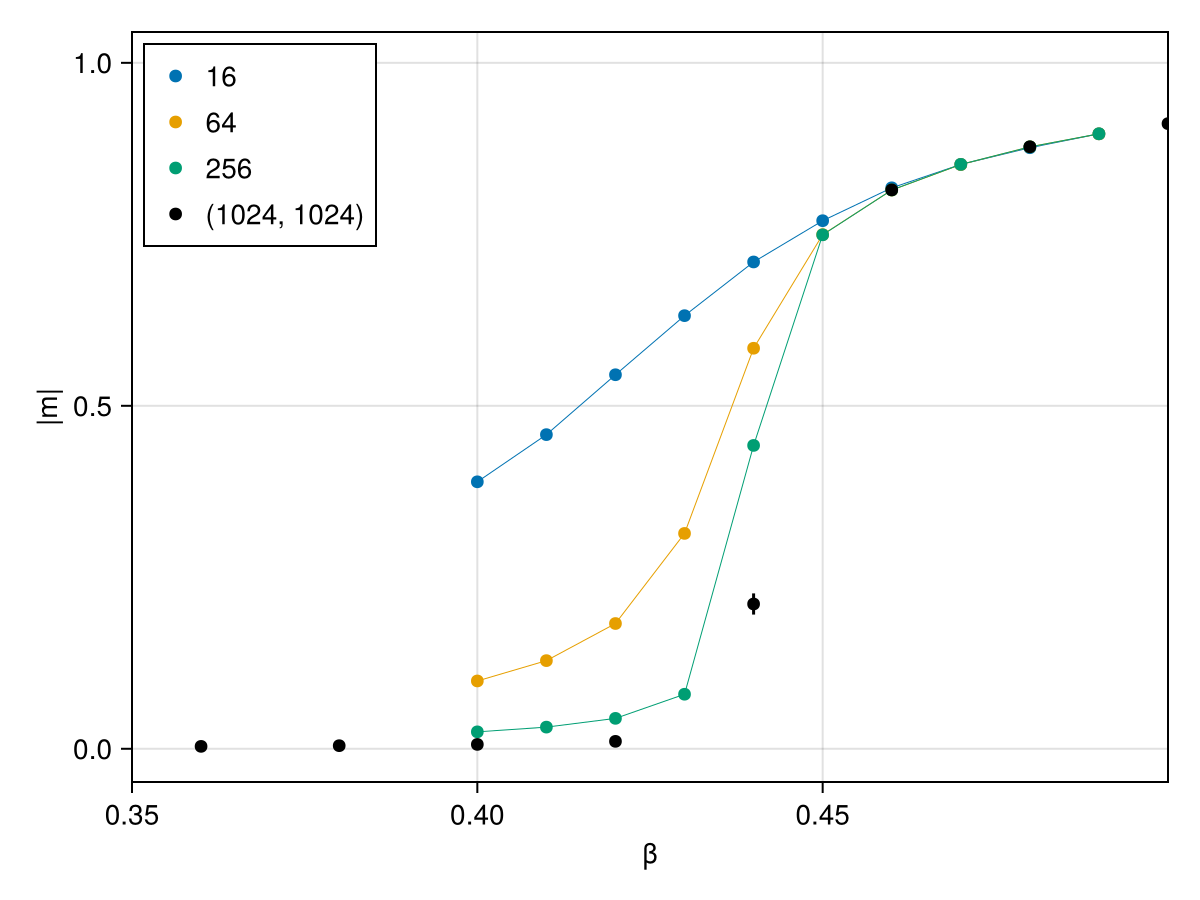

In [4]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="|m|")
for set in hrdata[2:2:end]
    betas=[set.betas...]
    ave_error=stats(set,:maglists,x->abs.(x))
    ave=[m[1] for m in ave_error]
    err=[m[2] for m in ave_error]
    plot!(ax,betas,ave,label=string(set.arraysize[1]))
    errorbars!(ax,betas,ave,err)
    lines!(ax,betas,ave,linewidth=0.5)
end
set=data[end]
betas=[set.betas...]
ave_error=stats(set,:maglists,x->abs.(x))
ave=[m[1] for m in ave_error]
err=[m[2] for m in ave_error]
plot!(ax,betas,ave,label=string(set.arraysize),color=:black)
errorbars!(ax,betas,ave,err,color=:black)
axislegend( position = :lt)
xlims!(ax,0.35,0.5)
f

The other way to display the data is as "finite size scaling, looking at how the magnetization evolves with system size:

In [5]:
function dataarrays(data)
    betas=[data[1].betas...]
    sizes=[d.arraysize[1] for d in data]
    numbetas=length(betas)
    numsizes=length(sizes)
    mdata=zeros(numsizes,numbetas)
    edata=zeros(numsizes,numbetas)
    for jb in 1:numbetas
        for js in 1:numsizes 
            timeseries=abs.(data[js].maglists[jb])
            ave_error=stats(timeseries)
            mdata[js,jb]=ave_error[1]
            edata[js,jb]=ave_error[2]
        end
    end
    return (betas=betas,sizes=sizes,mdata=mdata,edata=edata,
            numbetas=numbetas,numsizes=numsizes)
end

dataarrays (generic function with 1 method)

In [6]:
da=dataarrays(data)
hrda=dataarrays(hrdata);

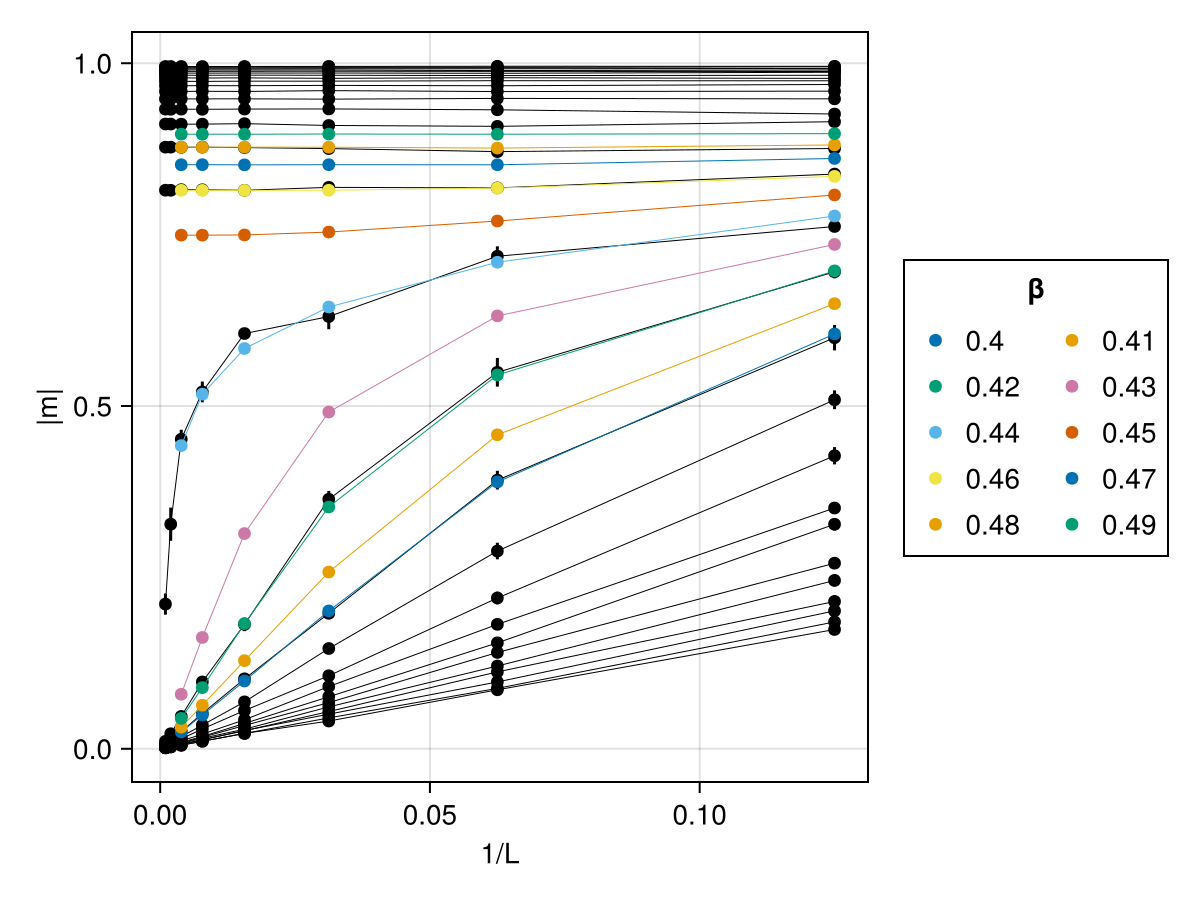

In [7]:
f=Figure()
ax=Axis(f[1,1],xlabel="1/L",ylabel="|m|")
plist=[]
for jb in 1:da.numbetas
    p=plot!(ax,1 ./da.sizes,da.mdata[:,jb],color=:black)
    errorbars!(ax,1 ./da.sizes,da.mdata[:,jb],da.edata[:,jb],color=:black)
    lines!(ax,1 ./da.sizes,da.mdata[:,jb],linewidth=0.5,color=:black)
end
for jb in 1:hrda.numbetas
    p=plot!(ax,1 ./hrda.sizes,hrda.mdata[:,jb])
    push!(plist,p)
    errorbars!(ax,1 ./hrda.sizes,hrda.mdata[:,jb],hrda.edata[:,jb])
    lines!(ax,1 ./hrda.sizes,hrda.mdata[:,jb],linewidth=0.5)
end

Legend(f[1,2],plist,[string(round(b,sigdigits=2)) for b in hrda.betas],"β",nbanks=2)
f    

However you slice it, the phase transition is somewhere between $\beta=0.44$ and $\beta=0.45$ 

The other beautiful thing we saw was the evolution of the free energy with temperature

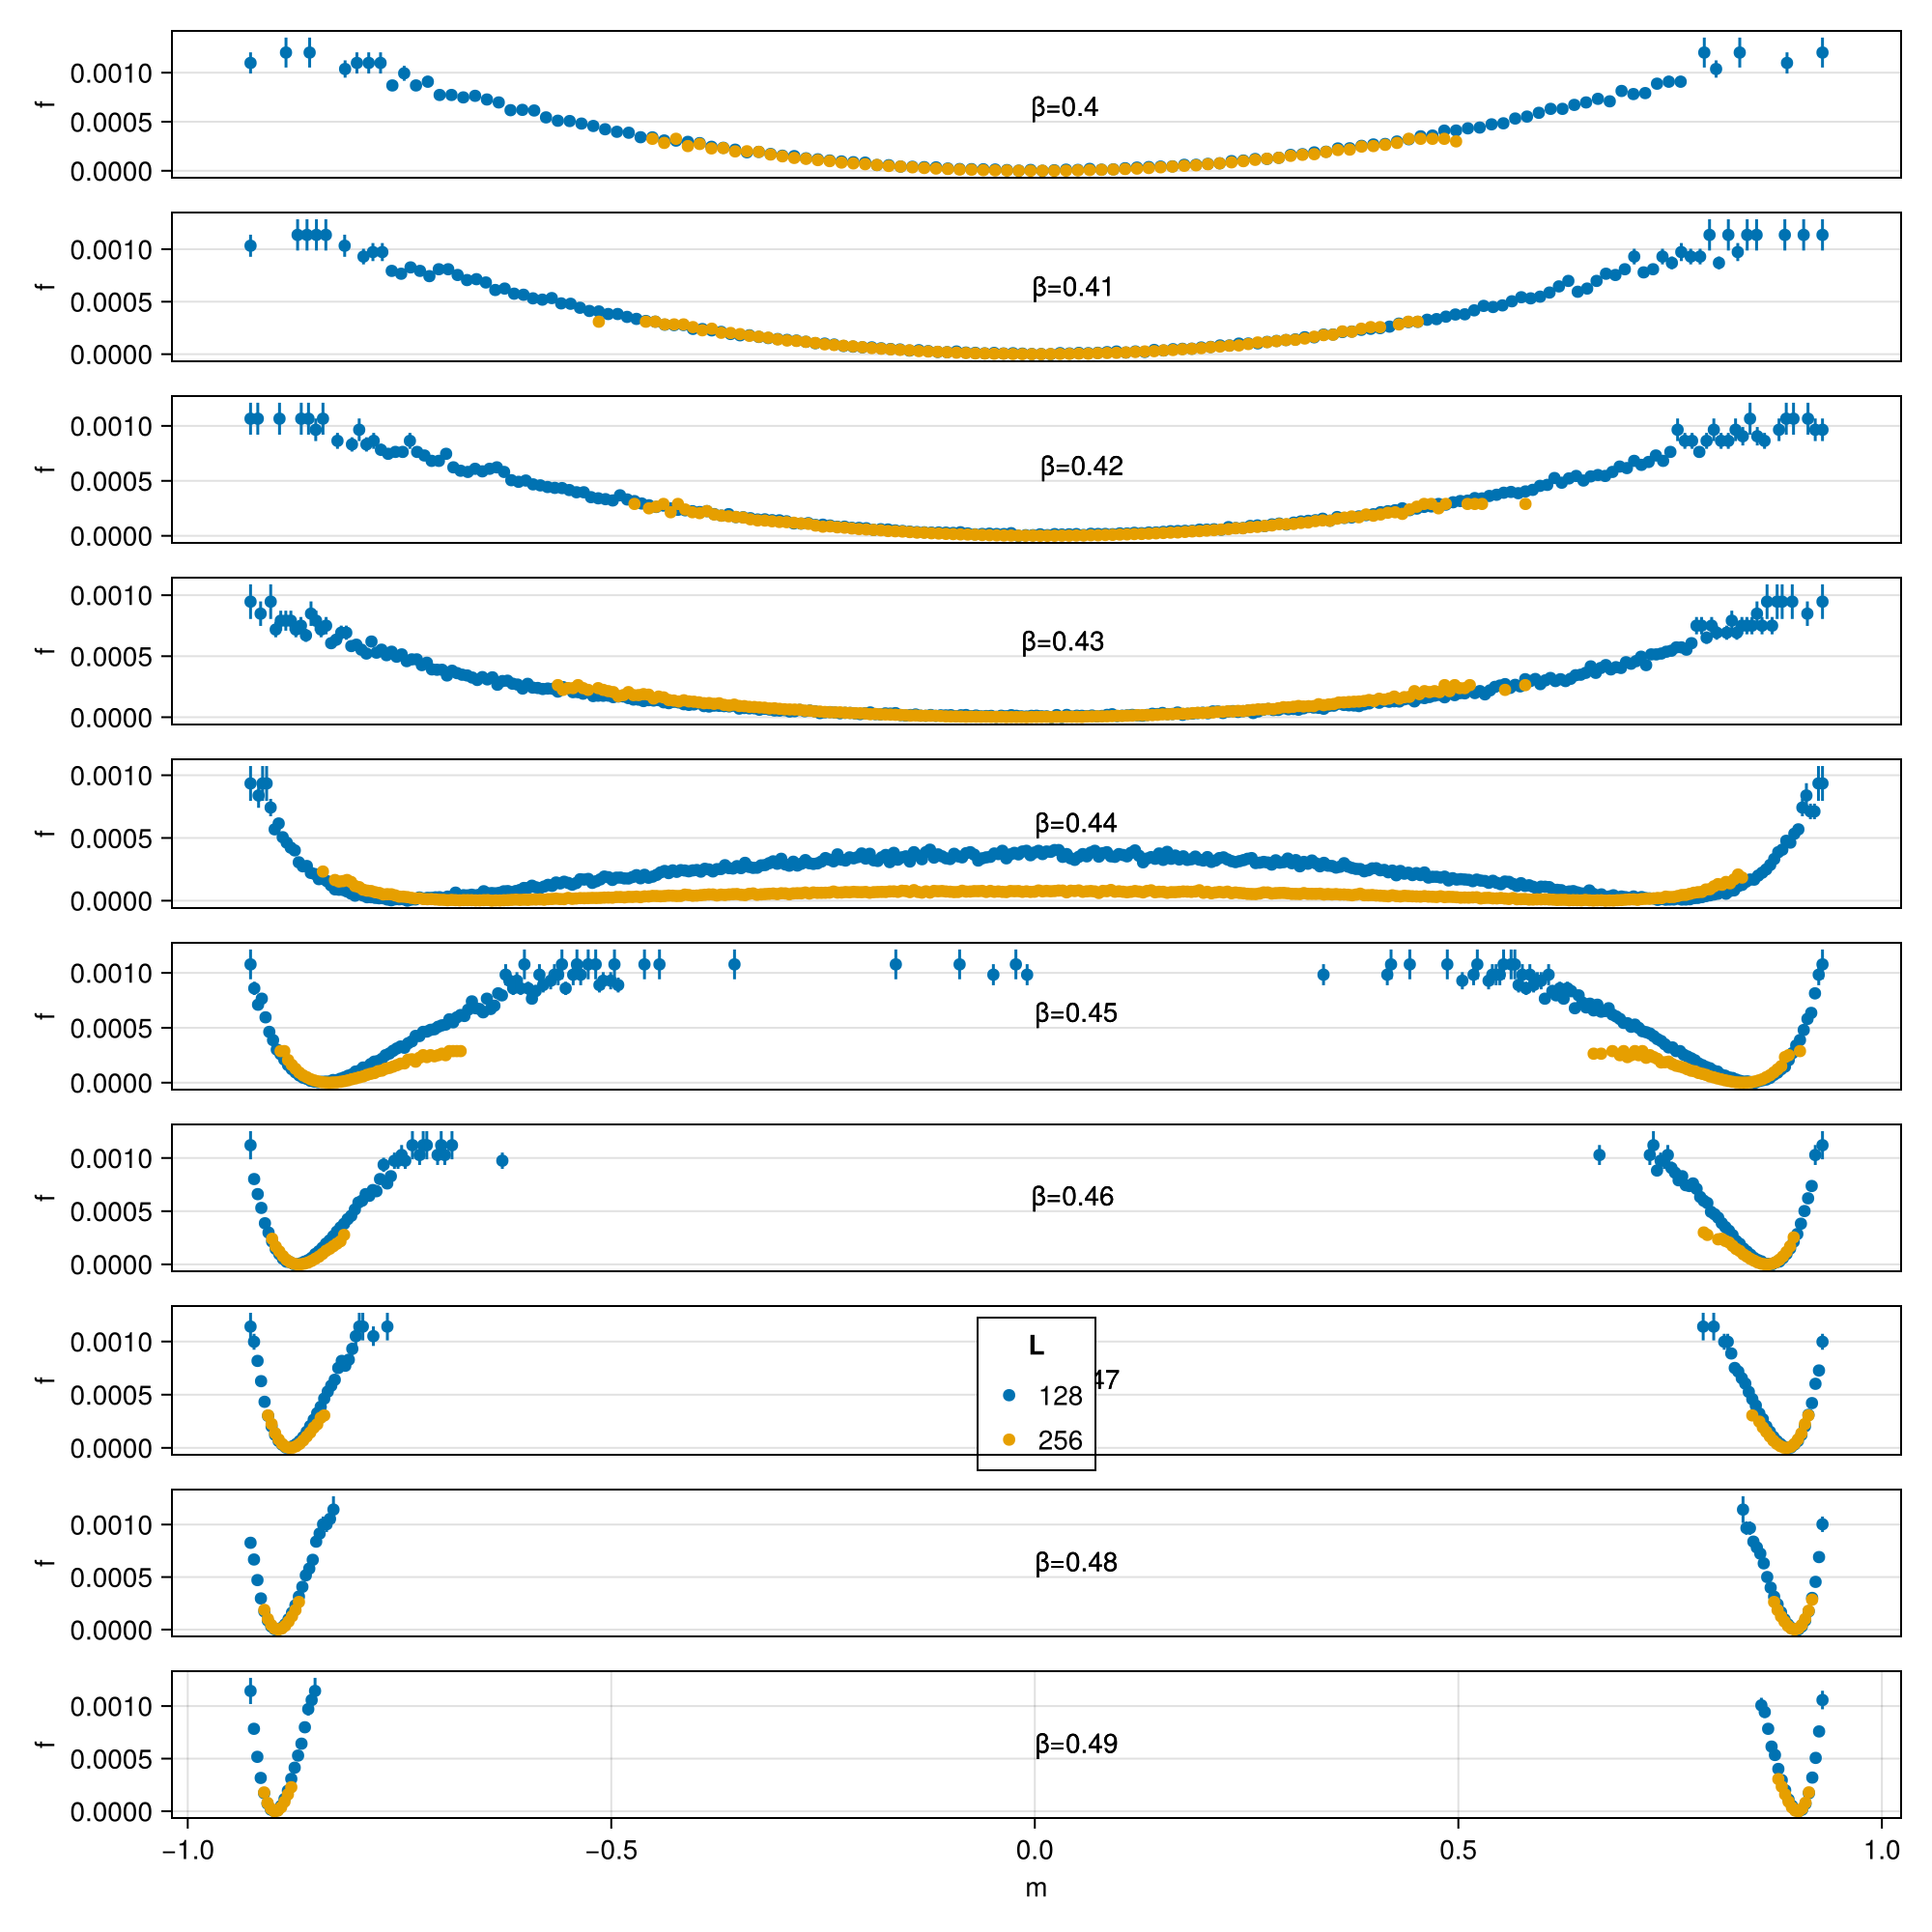

In [8]:
fig=Figure(size=(1000,1000))
betas=[hrdata[1].betas...]
sizes=[d.arraysize[1] for d in hrdata]
numbetas=length(betas)
numsizes=length(sizes)
for jb in 1:numbetas
    ax=Axis(fig[jb,1],xlabel="m",ylabel="f")
    #ylims!(ax,[0,0.01])
    for js in numsizes-1:numsizes
        f=freeenergy(hrdata[js].maglists[jb],betas[jb],sizes[js]^2,-1.,1.,500)
        plot!(ax,f.xvals,f.fvals,label=string(sizes[js]))
        errorbars!(ax,f.xvals,f.fvals,f.err)
        text!(ax,position=(0,0.0005),"β="*string(round(betas[jb],sigdigits=2)))
    end
    if jb<numbetas
       hidexdecorations!(ax) 
    end
    if jb==numbetas-2
        axislegend(ax,position = :ct,"L")
    end
end
fig

## Binder Cumulants

It is worth thinking a bit more about what is a really good way to find the transition temperature.  Yes, the behavior of $\langle |m|\rangle$ can be used to find it -- but is that really the best metric?

The defining feature of the paramagnet is that in the limit $N\to\infty$, the probability distribution is a Gaussian centered at the origin.  The defining feature of the ferromagnet is that in the limit $N\to\infty$ it is two Gaussians, centered at finite magnetizations.  

In some sense $\langle |m|\rangle$ distinguishes these two distributions through its $N$ dependence:  In the paramagnetic phase $\langle |m|\rangle \sim N^{-1/2}$.  In the ferromagnet it approaches a constant.  There is, however a more direct way to asses the shape of the probability distribution, taking moments.

To reiterate, above $T_c$ we see that $P(m)$ is a Gaussian centered at the origin with a width that scales with $1/\sqrt{N}$.  Thus we write
\begin{align}
P(m)&\propto \exp\left(-\frac{N m^2}{2\lambda^2}\right).
\end{align}
If we take moments we get
\begin{align}
\langle m^2\rangle &= \frac{\lambda^2}{N}\\
\langle m^4 \rangle &= 3 \left(\frac{\lambda^2}{N}\right)^2.
\end{align}

Below $T_c$ we instead see that $P(m)$ is two Gaussians, centered at $\pm m_0$,
\begin{align}
P(m)&\propto \exp\left(-\frac{N (m-m_0)^2}{2\lambda^2}\right)
+\exp\left(-\frac{N (m+m_0)^2}{2\lambda^2}\right)
.
\end{align}
And hence the moments are
\begin{align}
\langle m^2\rangle &=m_0^2+ \frac{\lambda^2}{N}
\langle m^4\rangle &=m_0^4+\cdots
\end{align}
I didn't bother calculating the rest of the second expression, but it scales as $1/N$.

The interesting feature is we can distinguish the shapes of these distributions by looking at
\begin{equation}
b=\frac{\langle m^4\rangle}{\langle m^2\rangle^2}
\end{equation}
Above $T_c$,  $b\to 3$, while below $T_c$, $b\to 1$. **In the thermodynamic limit, the only temperature at which $b\neq 1,3$ is $T_c$.**  
A convenient way to find that temperature is to look at where curves of $b$ vs $T$ for different system sizes cross.

To make this concrete, lets calculate $b$ from our data

In [10]:
binder(data) = mean(data.^4)/mean(data.^2)^2

binder (generic function with 1 method)

It is nice to also calculate error bars, using our binning analysis

In [11]:
function ebinder(data) 
    d4= stats(data.^4)
    d2=stats(data.^2)
    b=d4[1]/d2[1]^2
    error=d4[2]/d2[1]+ 2*d2[2]*d4[1]/d2[1]^3
    return (b,error)
end

ebinder (generic function with 1 method)

We can now construct arrays:
- `betas` -- a list of the values of $\beta$ in our data -- length `Nb`
- `sizes` -- a list of the system sizes -- length `Ns`
- `bdat` -- a `Nb` by `Ns` matrix that contains the binder cumulant for each parameter
- `ebdat` -- a `Nb` by `Ns` matrix that contains the error in the binder cumulant

In [12]:
betas=data[1].betas
sizes=[d.arraysize[1] for d in data]
bdat=zeros(length(sizes),length(betas))
ebdat=zeros(length(sizes),length(betas))
for size_index in 1:length(data)
    for beta_index in 1:length(betas)
        d=data[size_index]
        mlist=d.maglists[beta_index]
        b=ebinder(mlist)
        bdat[size_index,beta_index]=b[1]
        ebdat[size_index,beta_index]=b[2]
    end
end

Now we plot them

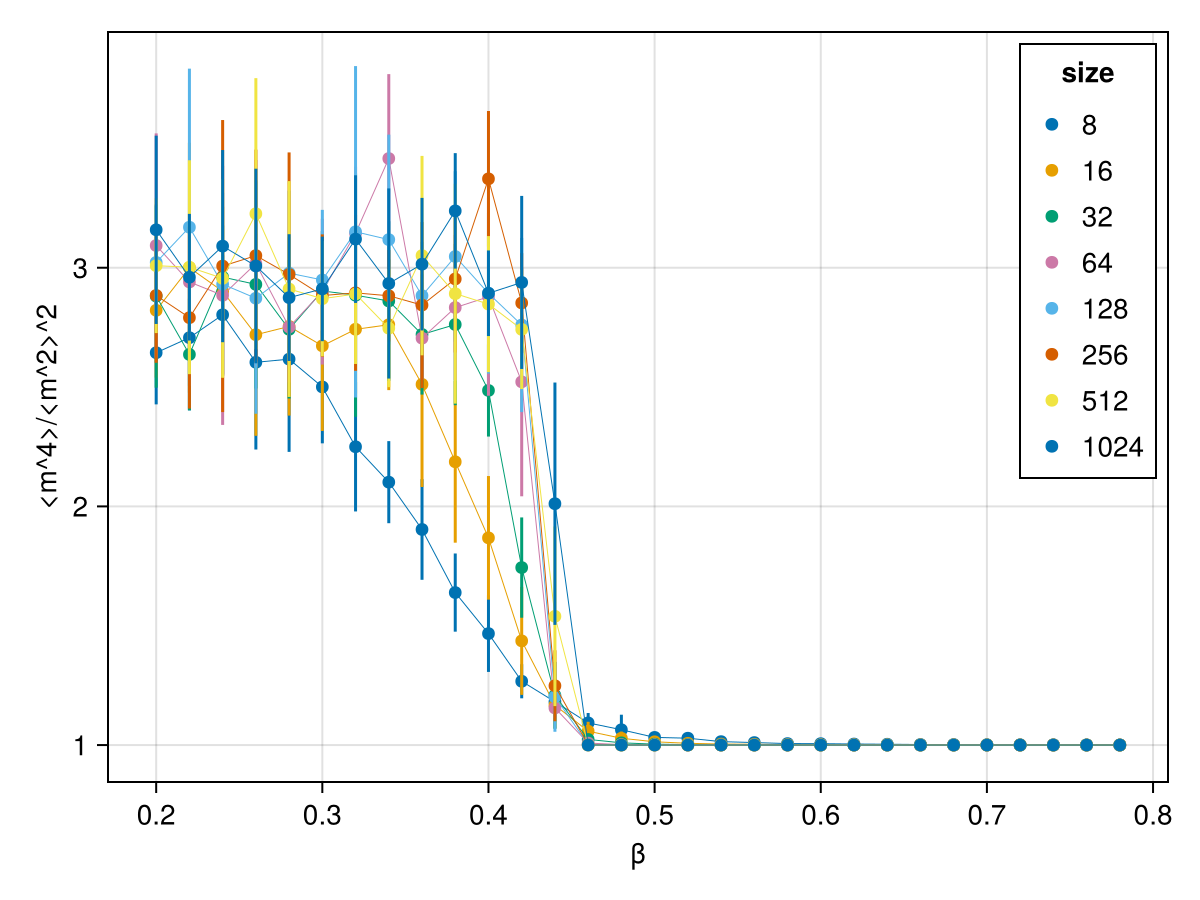

In [13]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="<m^4>/<m^2>^2")
for size_index in 1:length(data)
    plot!(betas,bdat[size_index,:],label=string(sizes[size_index]))
    lines!(betas,bdat[size_index,:],linewidth=0.5)
    errorbars!(betas,bdat[size_index,:],ebdat[size_index,:])
end
axislegend(ax,"size", position = :rt)
f

Qualitatively that look good.  For high temperatures the cumulant approaches 3 in the thermodynamic limit.  At low temperatures it appears to always be very close to 1:  Again, it gets better as the system size becomes larger.  Unfortunately the error bars are big, making it hard to say things too quantitatively.  

Lets zoom into the range $\beta$ from 0.4 to 0.5 and restrict to our higher resolution data:

In [14]:
betas=hrdata[1].betas
sizes=[d.arraysize[1] for d in hrdata]
bdat=zeros(length(sizes),length(betas))
ebdat=zeros(length(sizes),length(betas))
for size_index in 1:length(hrdata)
    for beta_index in 1:length(betas)
        d=hrdata[size_index]
        mlist=d.maglists[beta_index]
        b=ebinder(mlist)
        bdat[size_index,beta_index]=b[1]
        ebdat[size_index,beta_index]=b[2]
    end
end

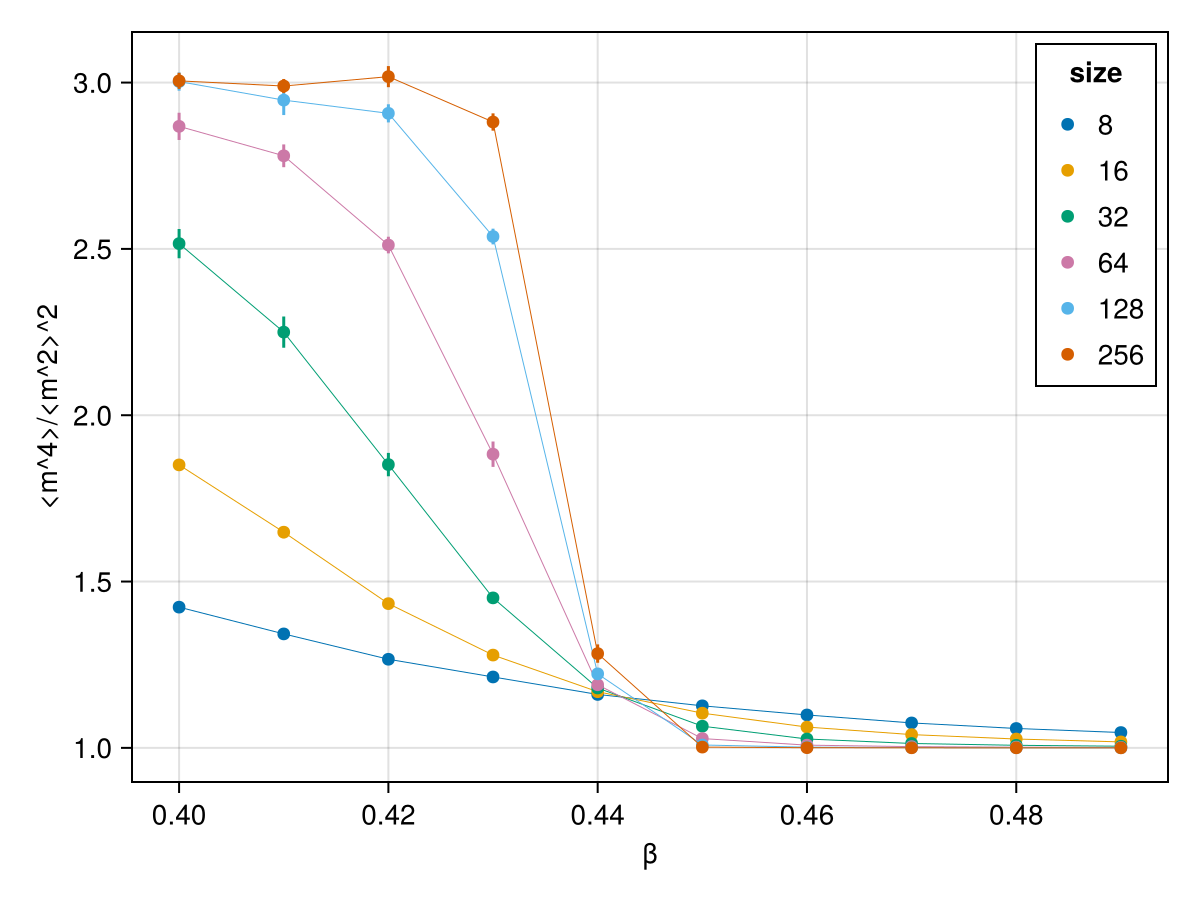

In [15]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="<m^4>/<m^2>^2")
for size_index in 1:length(hrdata)
    plot!(betas,bdat[size_index,:],label=string(sizes[size_index]))
    lines!(betas,bdat[size_index,:],linewidth=0.5)
    errorbars!(betas,bdat[size_index,:],ebdat[size_index,:])
end
axislegend(ax,"size", position = :rt)
f

That looks a lot better. One definitely sees qualitatively different behavior when 
β<0.44 and β>0.45. Another good way to look at the data is to take slices at fixed 
β, and look at how the Binder Cumulant scales with 1/L:

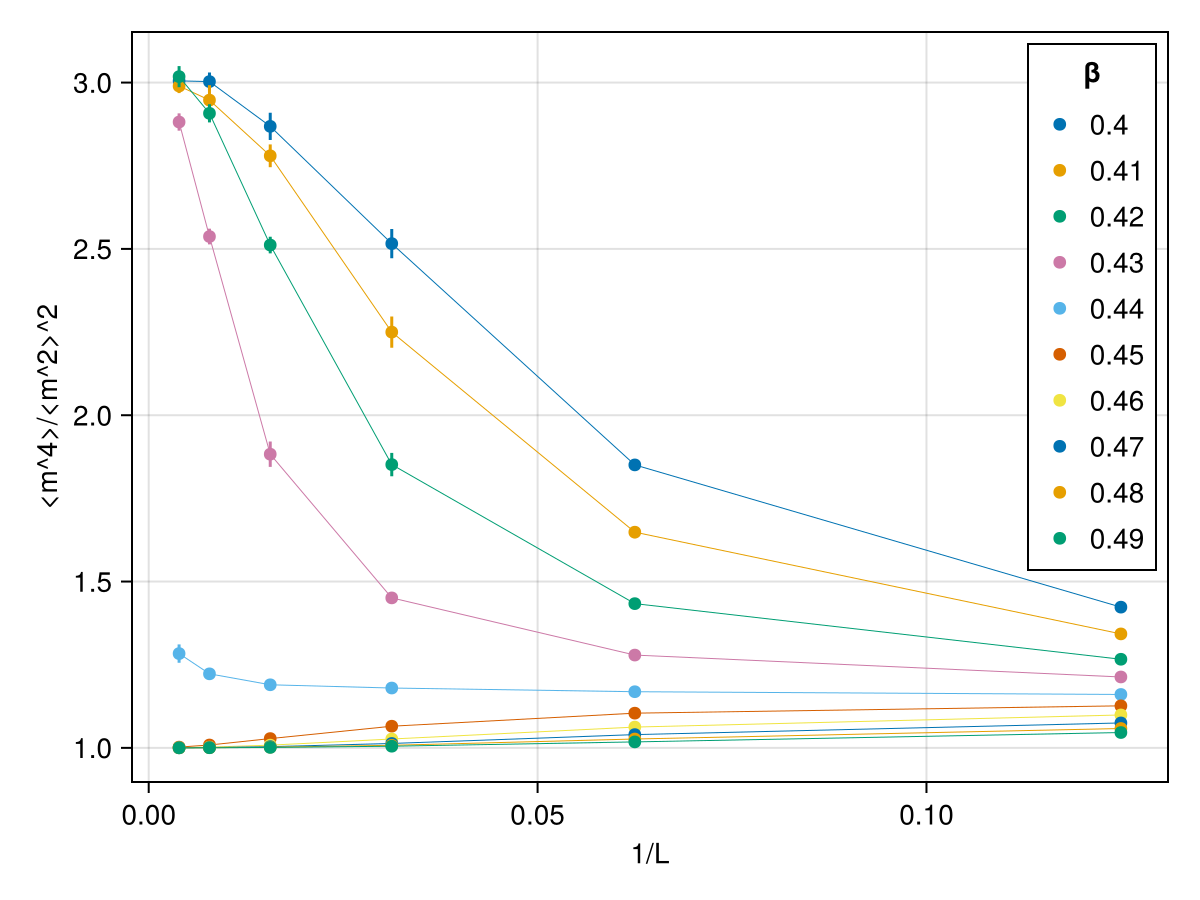

In [16]:
f=Figure()
ax=Axis(f[1,1],xlabel="1/L",ylabel="<m^4>/<m^2>^2")
for beta_index in 1:length(betas)
    plot!(1 ./sizes,bdat[:,beta_index],
        label=string(round(betas[beta_index],sigdigits=2)))
    lines!(1 ./sizes,bdat[:,beta_index],linewidth=0.5)
    errorbars!(1 ./sizes,bdat[:,beta_index],ebdat[:,beta_index])
end
axislegend(ax,"β", position = :rt)
f

The critical temperature is the separatrix between a curve that goes up to 3 as $L\to\infty$ and one that goes to $1$.  The $\beta=0.44$ curve is almost the separatrix -- but it goes up at the largest system size.

There is a nice trick for finding the separatrix, which has the property that $b_{\beta_c}(L)$ approaches a constant as $L\to \infty$.  Therefore if we look at the $\beta$'s for which $b_{\beta}(L)=b_{\beta}(L/2)$.  Those $\beta$'s will approach $\beta_c$ as $L\to \infty$.

### Interpolation

To find these crossing points we need to interpolate the data.  The simplest interpolation is just linear interpolation, we draw straight lines between our data points.  That can work, but we need much more closely chosen $\beta$ points.

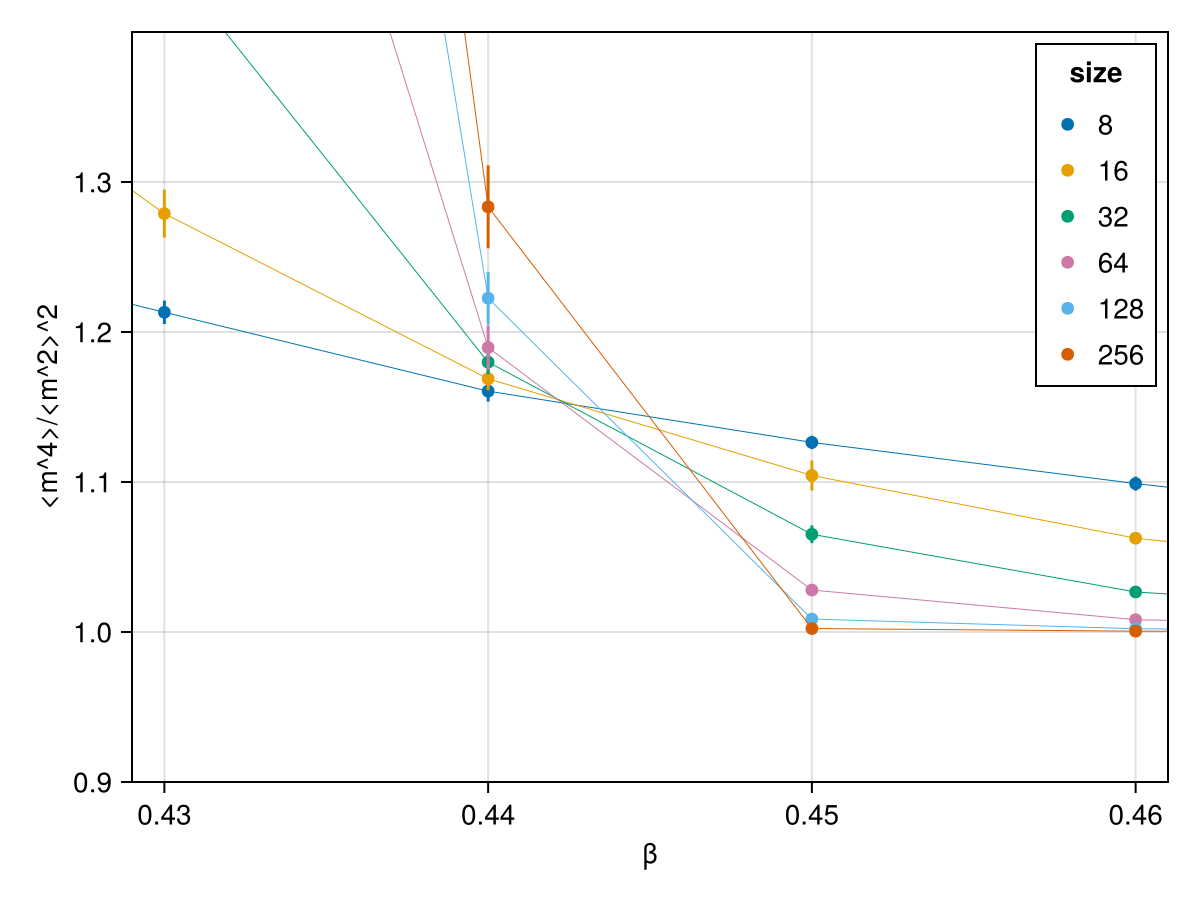

In [17]:
using CairoMakie.GeometryBasics
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="<m^4>/<m^2>^2")
for size_index in 1:length(hrdata)
    plot!(betas,bdat[size_index,:],label=string(sizes[size_index]))
    lines!(betas,bdat[size_index,:],linewidth=0.5)
    errorbars!(betas,bdat[size_index,:],ebdat[size_index,:])
end
axislegend(ax,"size", position = :rt)
xlims!(ax,0.429,0.461)
ylims!(ax,0.9,1.4)
f

It is clear that those linear interpolations are not going to be great.

To put ourselves in a better position, lets take some more data, but more finely spaced near the nominal transition point:

In [ ]:
#for j in 3:8
#    println("generating data for j="*string(j))
#    @time data=tempsweep(2^j,2^j,0.44,0.445,0.001,10,100000)
#    filename="hhr"*string(j)*".h5"
#    savesweep(data,filename)
#    println("saved data in file "*string(filename))
#    println()
#end

In [18]:
hhrdatafile=["hhr"*string(j)*".h5" for j in 3:8]
hhrdata=[loadsweep(file) for file in hhrdatafile];

In [19]:
betas=hhrdata[1].betas
sizes=[d.arraysize[1] for d in hhrdata]
bdat=zeros(length(sizes),length(betas))
ebdat=zeros(length(sizes),length(betas))
for size_index in 1:length(hhrdata)
    for beta_index in 1:length(betas)
        d=hhrdata[size_index]
        mlist=d.maglists[beta_index]
        b=ebinder(mlist)
        bdat[size_index,beta_index]=b[1]
        ebdat[size_index,beta_index]=b[2]
    end
end

We can then plot a zoomed in view of the Binder Cumulants

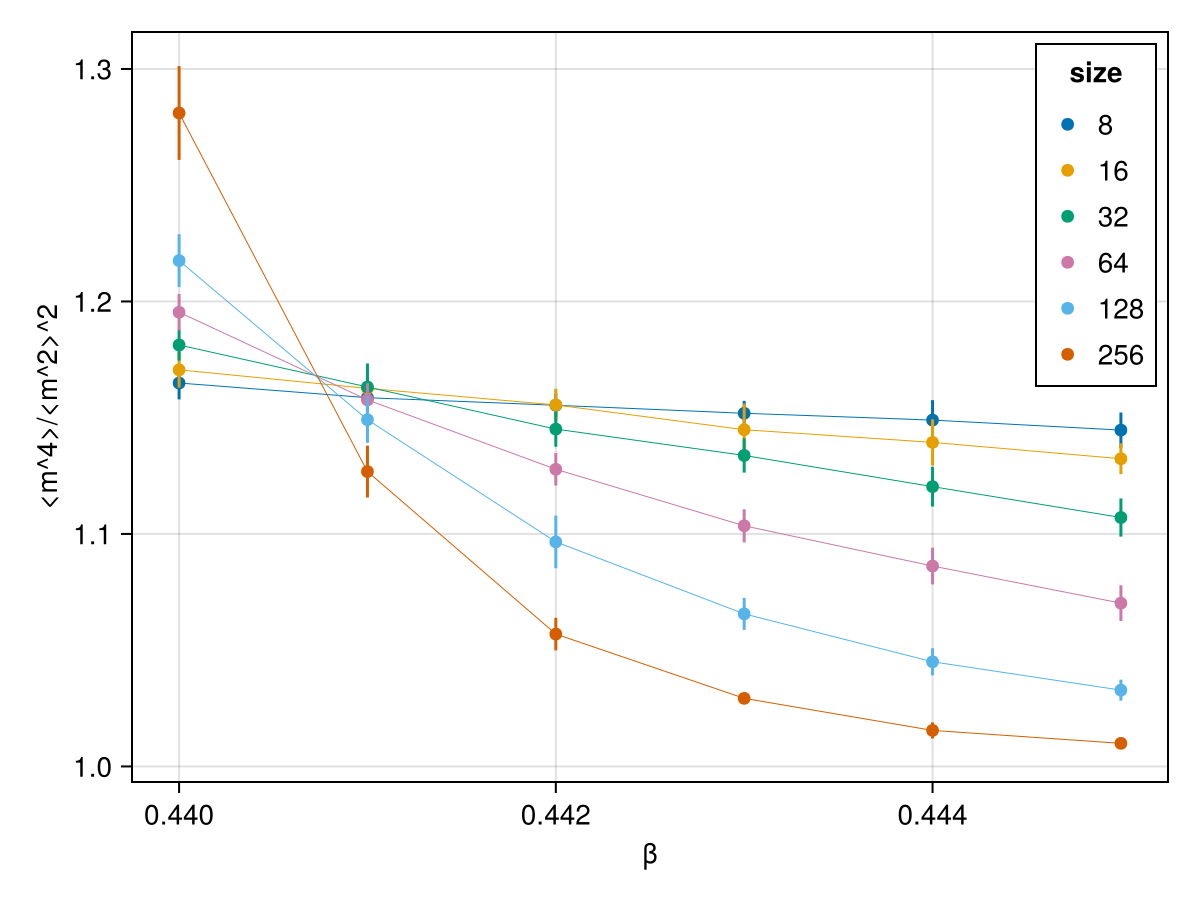

In [20]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="<m^4>/<m^2>^2")
for size_index in 1:length(hhrdata)
    plot!(betas,bdat[size_index,:],label=string(sizes[size_index]))
    lines!(betas,bdat[size_index,:],linewidth=0.5)
    errorbars!(betas,bdat[size_index,:],ebdat[size_index,:])
end
axislegend(ax,"size", position = :rt)
f

We can now get an excellent approximaiton to the phase transition point by looking at where those curves cross.  

Here is what it looks like if we plot the cumulant vs system size:

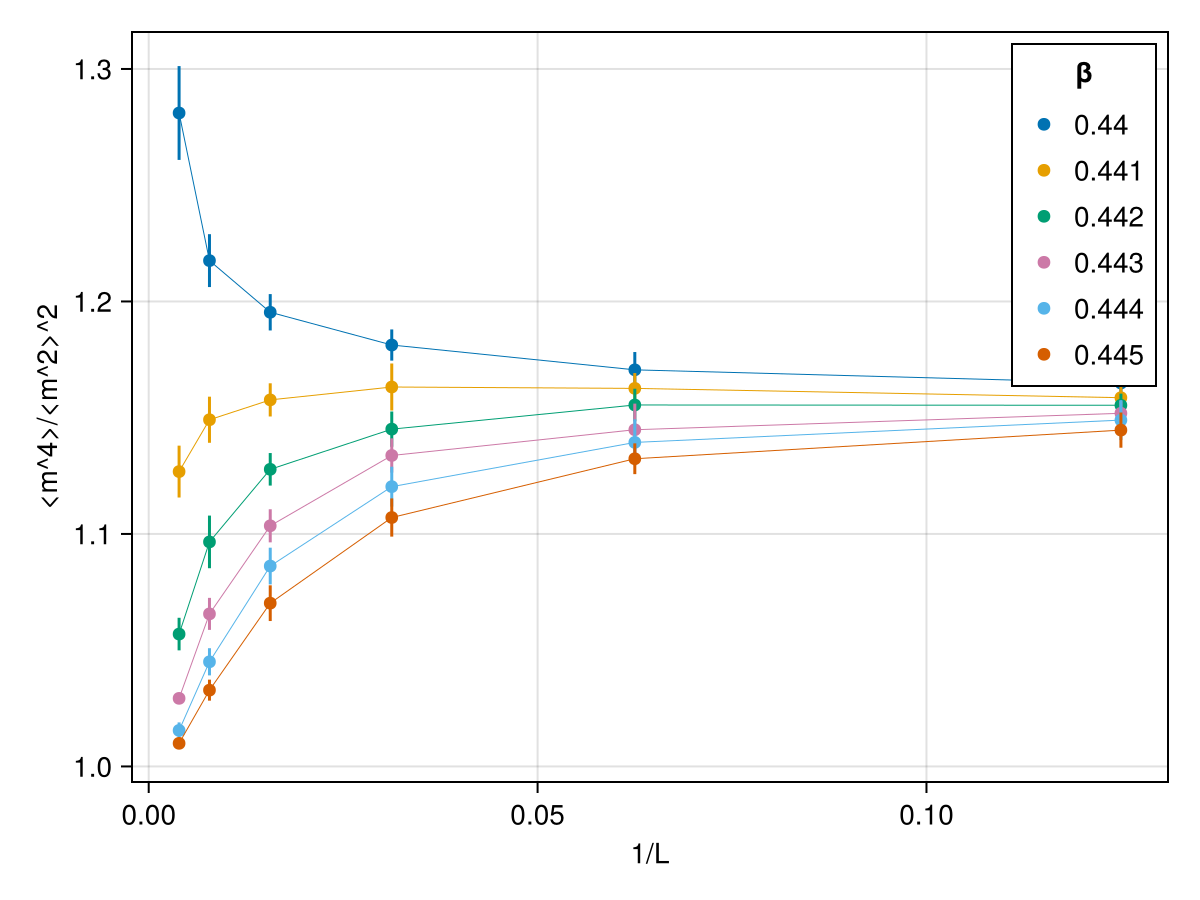

In [21]:
f=Figure()
ax=Axis(f[1,1],xlabel="1/L",ylabel="<m^4>/<m^2>^2")
for beta_index in 1:length(betas)
    plot!(1 ./sizes,bdat[:,beta_index],
        label=string(round(betas[beta_index],sigdigits=3)))
    lines!(1 ./sizes,bdat[:,beta_index],linewidth=0.5)
    errorbars!(1 ./sizes,bdat[:,beta_index],ebdat[:,beta_index])
end
axislegend(ax,"β", position = :rt)
f

### Polynomial Interpolation

Instead of linear interpolation, we will use a quadratic interpolation, fitting a parabola through the first 3 data points.  We will then look for where those polynomials cross.  We will just use a package for this -- though coding it ourself is straightforward.

In [22]:
using Polynomials
fits=[]
for size_index in 1:length(hhrdata)
    ft=fit(betas[1:3],bdat[size_index,1:3])
    push!(fits,ft)
end
fits

6-element Vector{Any}:
 Polynomial(299.9539613498849 - 1350.2960629071035*x + 1525.522850541192*x^2)
 Polynomial(86.25676256554286 - 378.35763079367246*x + 420.4089905966982*x^2)
 Polynomial(3.630719633366267 + 6.89444292861929*x - 28.32136240216163*x^2)
 Polynomial(776.7208909795327 - 3483.5206545840338*x + 3911.2786314314717*x^2)
 Polynomial(1572.7826345626734 - 7067.09496052975*x + 7943.991288975262*x^2)
 Polynomial(8252.058690410457 - 37307.12910575391*x + 42171.27673957591*x^2)

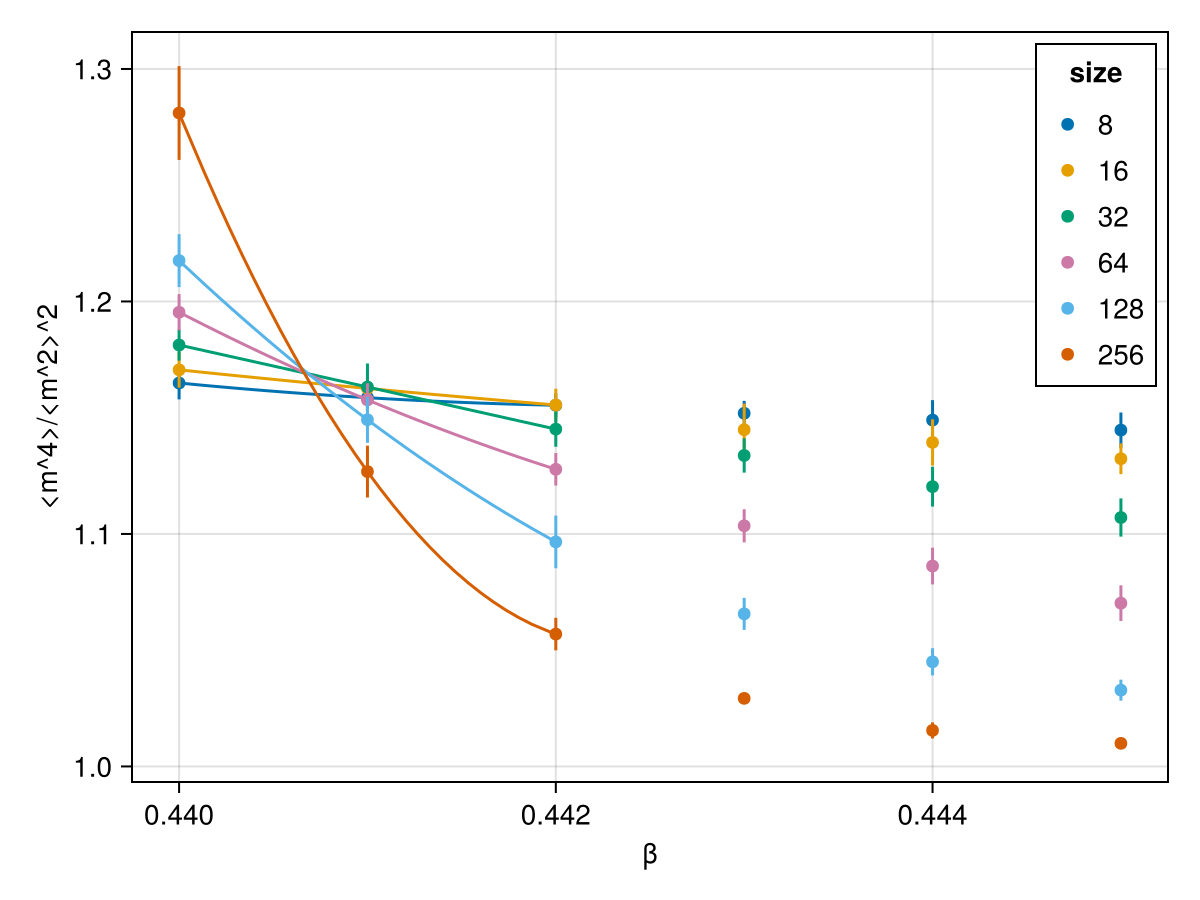

In [23]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="<m^4>/<m^2>^2")
for size_index in 1:length(hhrdata)
    plot!(betas,bdat[size_index,:],label=string(sizes[size_index]))
    lines!(betas[1]..betas[3],x->fits[size_index](x))
    errorbars!(betas,bdat[size_index,:],ebdat[size_index,:])
end
axislegend(ax,"size", position = :rt)
f

We can find the crossing points using the quadratic formula.  The package already has this built-in.  For example

In [24]:
rt=roots(fits[end]-fits[end-1])

2-element Vector{Float64}:
 0.44064922303177684
 0.4428574222401311

Of course, we see a complication.  The quadratic formula has two roots.  In this case the one we want is $\beta=0.44065...$.  To select the one we want, we will use the function `findmin`

In [25]:
findmin((rt.-0.441).^2)[2]

1

Which tells us that the first root is the one closest to 0.441 -- which is the one we want.

Lets now extract the crossing points

In [26]:
crossings=[]
for j in 1:length(sizes)-1
    rts=roots(fits[j+1]-fits[j])
    closestrootloc=findmin((rts.-0.441).^2)[2]
    append!(crossings,rts[closestrootloc])
end
crossings

5-element Vector{Any}:
 0.4420247676099254
 0.44105626630469746
 0.440673599363379
 0.44069466717846645
 0.44064922303177684

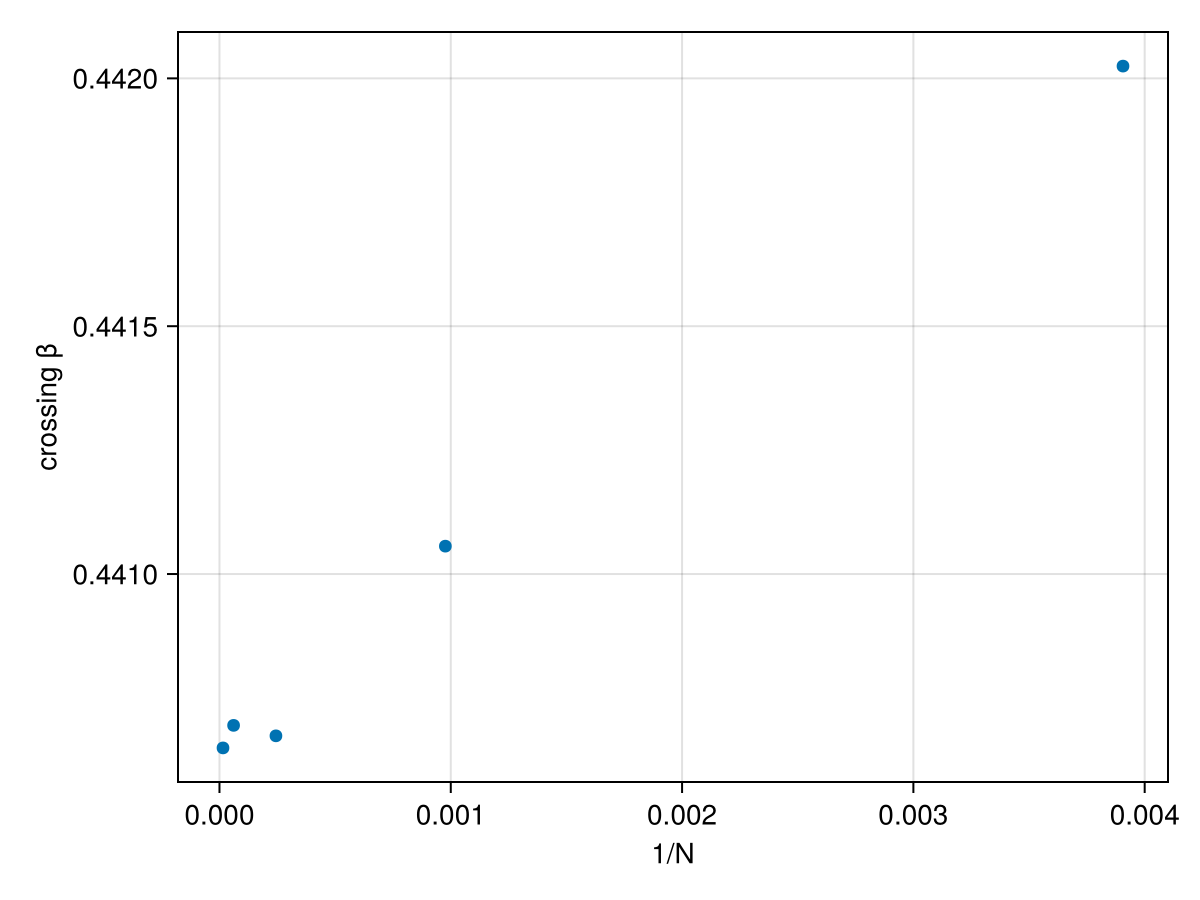

In [27]:
p=plot(1 ./sizes[2:end].^2,[crossings...])
p.axis.xlabel="1/N"
p.axis.ylabel="crossing β"
p

We can then extrapolate to the infinite size limit by using our standard fitting function

In [28]:
"""
    linearfit(X,Y,functions)

takes a set of `X=(x1,x2,...xn)`, `Y=(y1,y1,...yn)` and a set of `functions=(f1, f2,...fm)` 
and returns the set of coefficients `C=(c1,c2,..cm)` which minimize 


         n       m
    χ²=  ∑  (yi- ∑  cj fj(xi))^2
        i=1     j=1

It is implemented by constructing the `n×m` matrix `A` with matrix elements

    Aᵢⱼ= fj(xi)

then `(AᵗA)C=AᵗY`, where `Y=(y1,y2,...yn)`.  Thus the optimal coefficients are 
`(AᵗA)⁻¹(AᵗY)`, which can be implemented with `(AᵗA)\\(AᵗY)`.
"""
function linearfit(X,Y,functions)
    A=[f(x) for x in X, f in functions ]
    return transpose(A)*A\(transpose(A)*Y) # This is equivalent to (AᵗA)⁻¹(AᵗY)
end                                        # the "\" is "divide from left"

linearfit

In [29]:
betacrossingfit=linearfit(1 ./sizes[2:end].^2,[crossings...],(x->1.,x->x))

2-element Vector{Float64}:
 0.4406506583068553
 0.35463085435571445

Which gives our estimate of $\beta_c$ as $0.44065$

It turns out that the exact answer can be calculated analytically, and

In [30]:
betac=log(1+sqrt(2))/2

0.44068679350977147

We could, of course, get closer to this by taking a finer $\beta$ grid, and/or larger system sizes.

We could also estimate the error in our transition temperature by carefully propegating our statistical error bars.

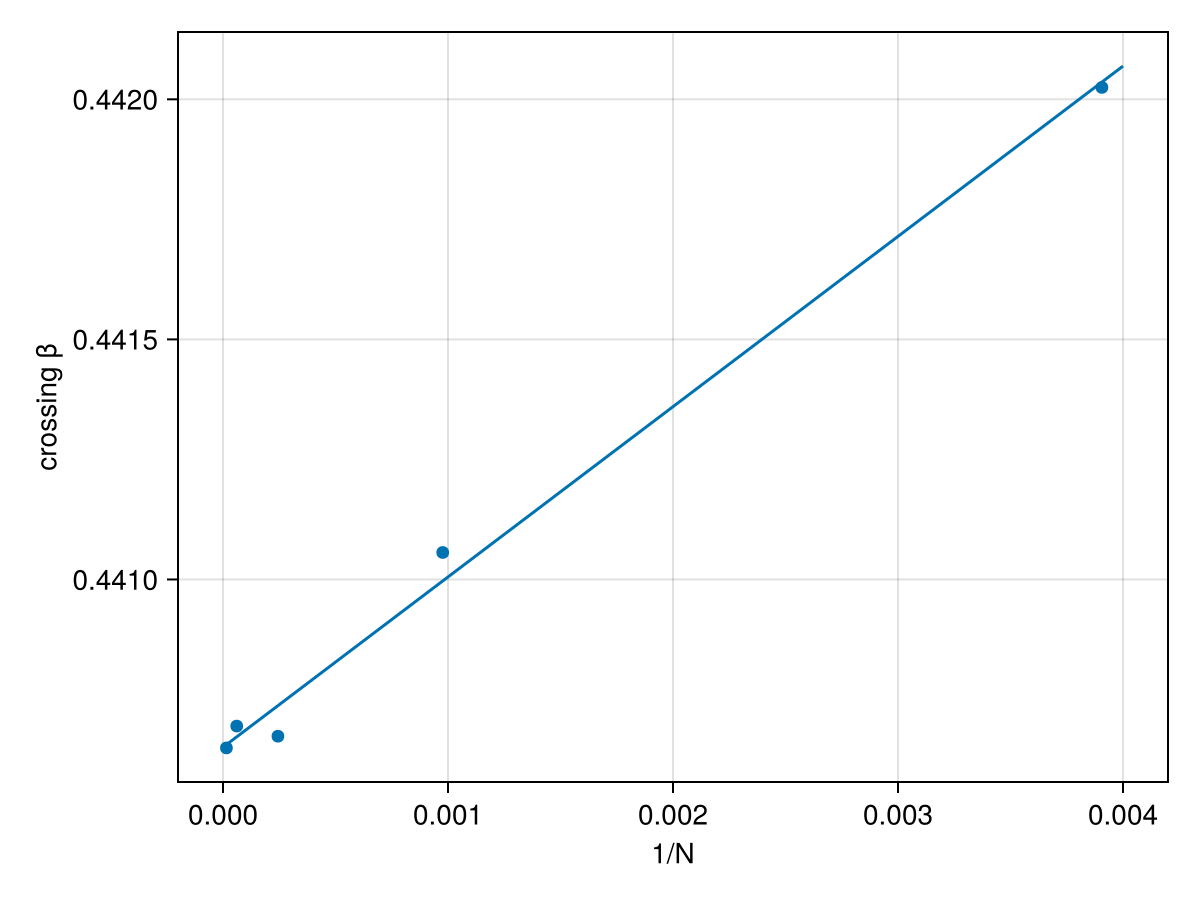

In [33]:
fitfun(x)=betacrossingfit[1]+x*betacrossingfit[2]
lines!(p.axis,0..0.004,fitfun)
p

## Scaling

One consequence of this analysis is that as $L\to\infty$, at $T_c$ the shape of $P(m)$ is independent of system size:

\begin{align}
P_{\beta_c,L}(m)&\propto
\exp\left(
-\beta_c F_{\beta_c}(m,L)
\right)
\\
&=\exp\left(-\beta_c f(m/\bar m_L)\right).
\end{align}

That is the free energy (or the probability distribution) approaches some univeral shape.  There is a characteristic scale $m_L$ which can depend on $L$, but the distribution can be rescaled to map onto itself.

This is reminiscent of what happened below $T_c$ -- where the distribution was always a Gaussian.  The width of the Gaussian varied with system size, but the shape was universal.

Lets do some runs at our nominal critical temperature, and check this scaling hypothesis

In [34]:
function critsims(minsize,maxsize)
    slist=[]
    simlist=[]
    for j in minsize:maxsize
        println("generating data for j="*string(j))
        s=rand_ising2d(2^j,2^j)
        @time sim=fullsimulate!(s,betac,0.,10,100000)
        push!(slist,s)
        push!(simlist,sim)
        println()
    end
    return (slist=[slist...],simlist=[simlist...])
end

critsims (generic function with 1 method)

In [124]:
#c1=critsims(3,9);

generating data for j=3
  0.402184 seconds (342.88 k allocations: 242.557 MiB, 5.03% gc time)

generating data for j=4
  1.211644 seconds (364.61 k allocations: 376.829 MiB, 3.88% gc time)

generating data for j=5
  3.955250 seconds (415.92 k allocations: 947.762 MiB, 1.20% gc time)

generating data for j=6
 14.222690 seconds (459.02 k allocations: 2.102 GiB, 0.83% gc time)

generating data for j=7
 58.791134 seconds (509.63 k allocations: 4.869 GiB, 0.43% gc time)

generating data for j=8
423.979465 seconds (562.87 k allocations: 11.631 GiB, 0.13% gc time)

generating data for j=9
3398.541682 seconds (608.71 k allocations: 28.551 GiB, 0.03% gc time)



In [35]:
function savecritsim(data,filename::String)
    sims=data.simlist
    realizations=data.slist
    sizes=[s.dims[1] for s in sims]
    h5open(filename, "w") do file
        println("writing realizations")
        rg=create_group(file,"realizations")
        for (j,s) in pairs(sizes)
            write(rg,string(s),realizations[j])
        end
        println("writing sizes")
        write(file,"sizes",sizes)
        println("writing magnetizations")
        write(file,"maglists",hcat([s.maglist for s in sims]...))
        println("writing Energies")
        write(file,"Elists",hcat([s.Elist for s in sims]...))
    end
end

loadcritsim(filename::String)=h5open(read,filename,"r")

loadcritsim (generic function with 1 method)

In [36]:
#savecritsim(c1,"crit.h5")

In [37]:
critdata=loadcritsim("crit.h5")

Dict{String, Any} with 4 entries:
  "realizations" => Dict{String, Any}("32"=>Int8[1 1 … 1 1; -1 -1 … -1 -1; … ; …
  "maglists"     => [0.8125 0.804688 … -0.0489807 0.528046; -0.875 -0.695312 … …
  "sizes"        => [8, 16, 32, 64, 128, 256, 512]
  "Elists"       => [-1.5625 -1.48438 … -1.39545 -1.41998; -1.625 -1.3125 … -1.…

In [38]:
cr=critdata["realizations"];
keys(cr)

KeySet for a Dict{String, Any} with 7 entries. Keys:
  "32"
  "512"
  "64"
  "256"
  "128"
  "16"
  "8"

Lets plot a typical realization

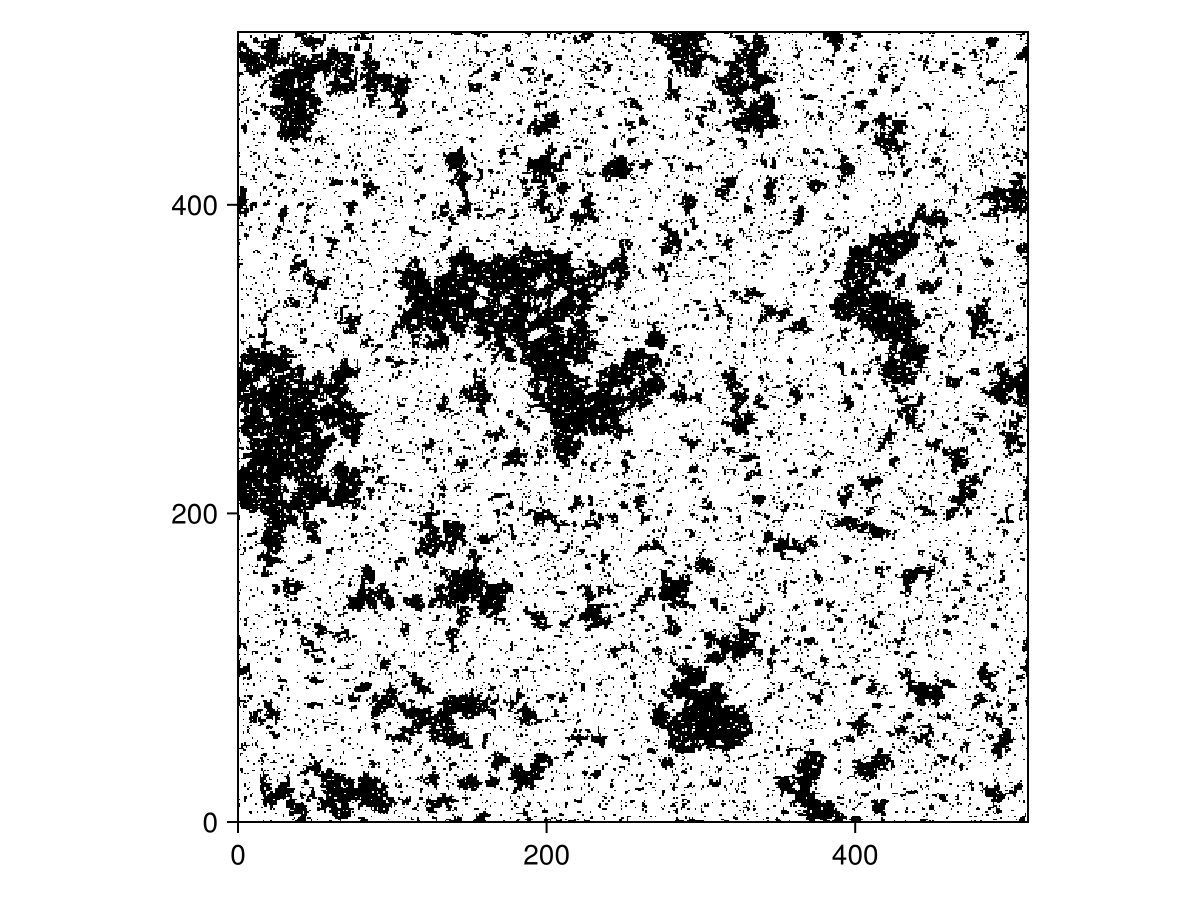

In [39]:
im=image(cr["512"],interpolate=false)
im.axis.aspect=1
im

That is pretty wild!  There are very funky looking domains of all sizes.  This is in fact a *fractal*.  Meaning if you zoom into one part of the picture you see something which is statistically identical to the full picture.

Lets now extract the expectation value of the absolute value of the magnetization, for each system size.

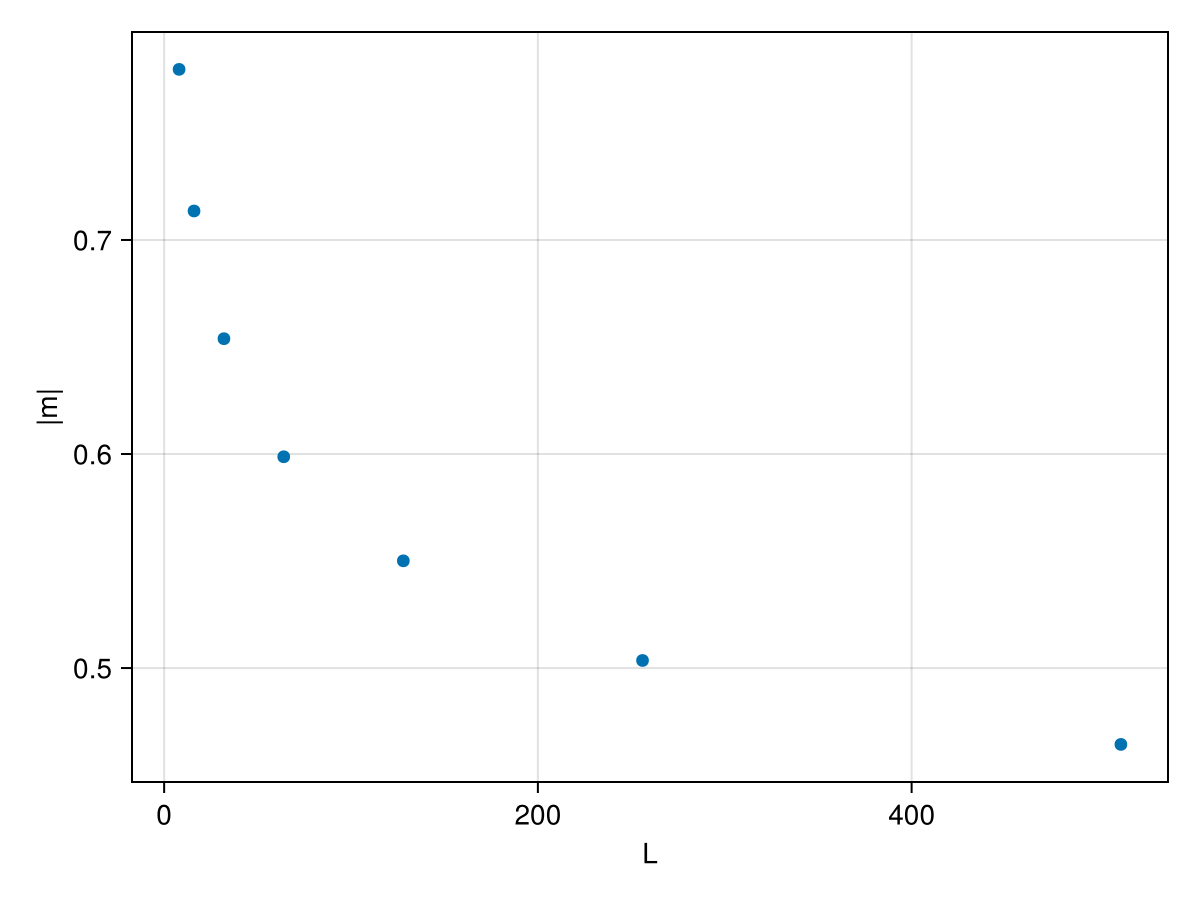

In [41]:
critmags=Float64[]
critmagerrs=Float64[]
critsizes=critdata["sizes"]
for j in 1:length(critsizes)
    m,err=stats(abs.(critdata["maglists"][:,j]))
    push!(critmags,m)
    push!(critmagerrs,err)
end
p=plot(critsizes,critmags)
p.axis.xlabel="L"
p.axis.ylabel="|m|"
errorbars!(critsizes,critmags,critmagerrs)
p

Interestingly -- that looks like a power law.  Lets make a log-log plot.

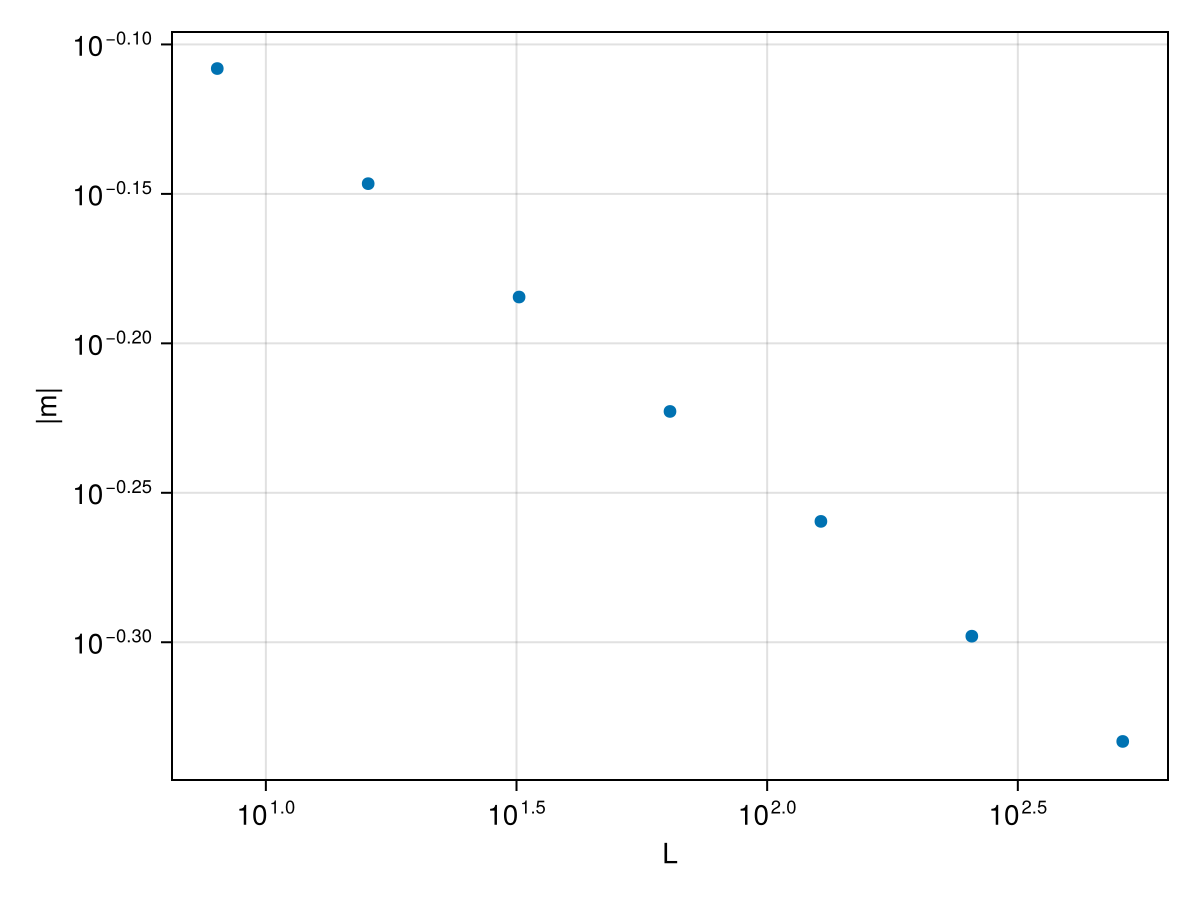

In [42]:
p=plot(critsizes,critmags)
p.axis.xlabel="L"
p.axis.ylabel="|m|"
p.axis.xscale=log10
p.axis.yscale=log10
errorbars!(critsizes,critmags,critmagerrs)
p

Wow, that is as nice of a power law as I have ever seen.  

This behavior is further evidence that the spin pattern is a fractal.

Lets fit the data to extract the power:

In [45]:
lf=linearfit(log.(critsizes),log.(critmags),[x->1.,x->x])

2-element Vector{Float64}:
  0.008926458815378601
 -0.1249506815997758

In [47]:
-1/(lf[2])

8.003157623445844

This tells us that at the critical point $\langle|m|\rangle\sim L^{-\delta}$ apparently with $\delta=1/8$.

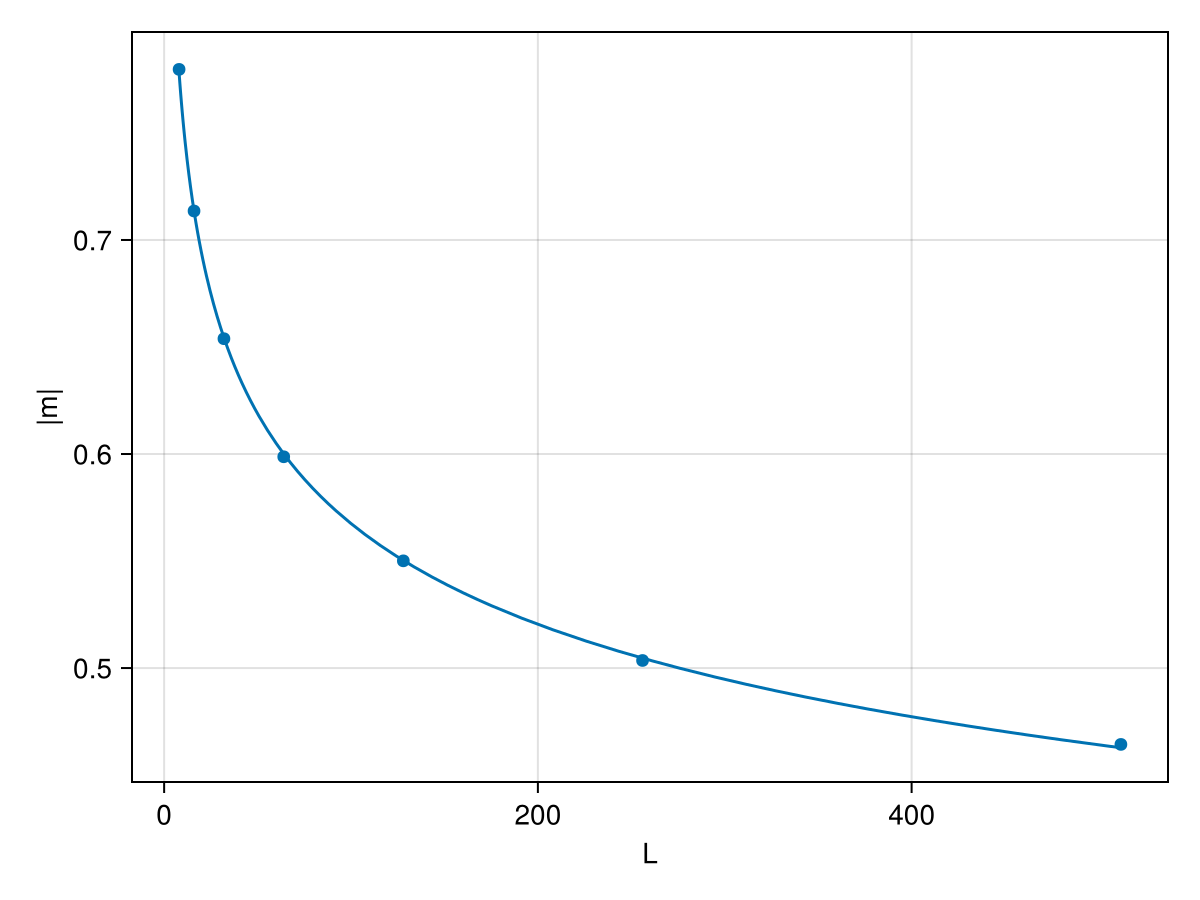

In [48]:
p=lines(2^3..2^9,L->exp(lf[1])*L^lf[2])
plot!(critsizes,critmags)
p.axis.xlabel="L"
p.axis.ylabel="|m|"
errorbars!(critsizes,critmags,critmagerrs)
p

Now lets plot the probability distributions

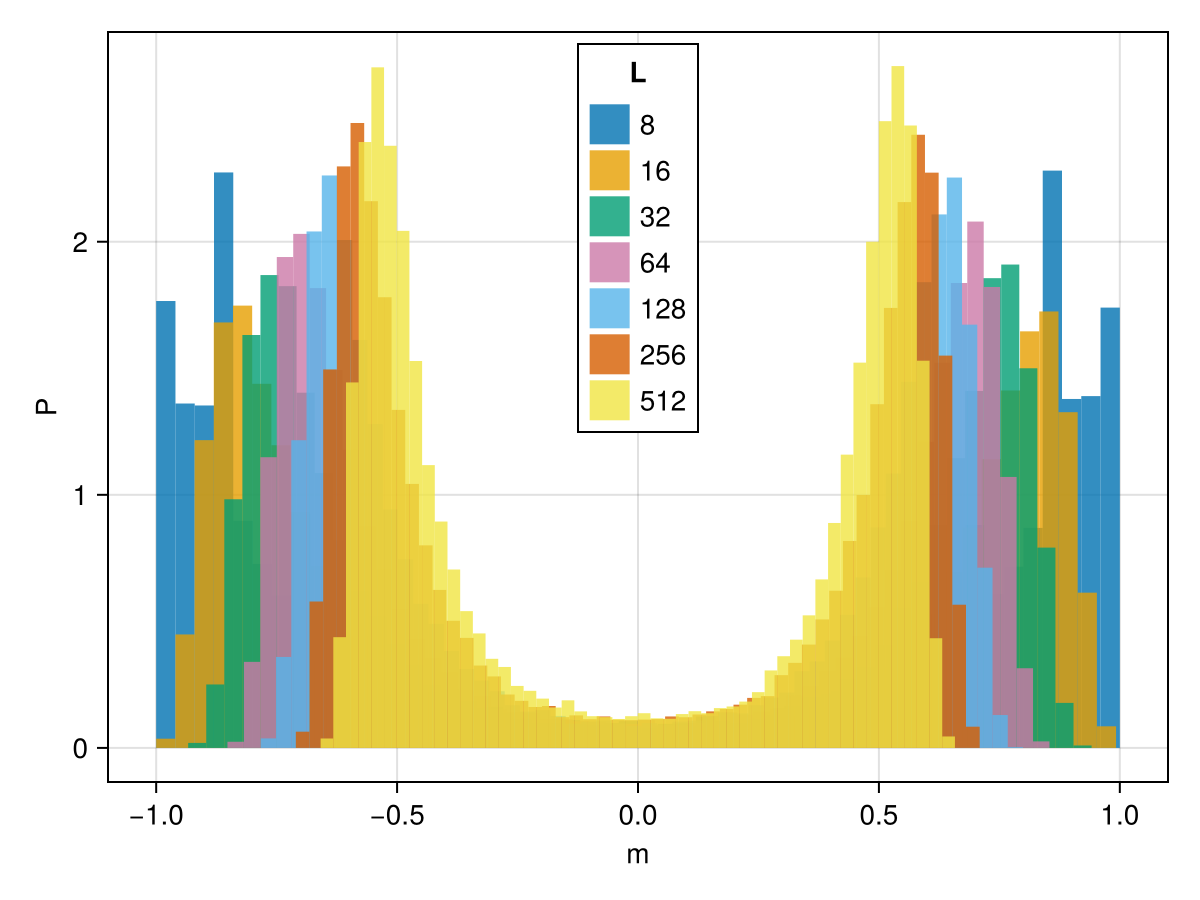

In [49]:
f=Figure()
ax=Axis(f[1,1],xlabel="m",ylabel="P")
for (j,L) in pairs(critdata["sizes"])
    hist!(critdata["maglists"][:,j],bins=50,normalization=:pdf,label=string(L))
end
axislegend(ax,"L",position=:ct)
f

Now lets rescale the magnetizations by $\langle |m|\rangle$

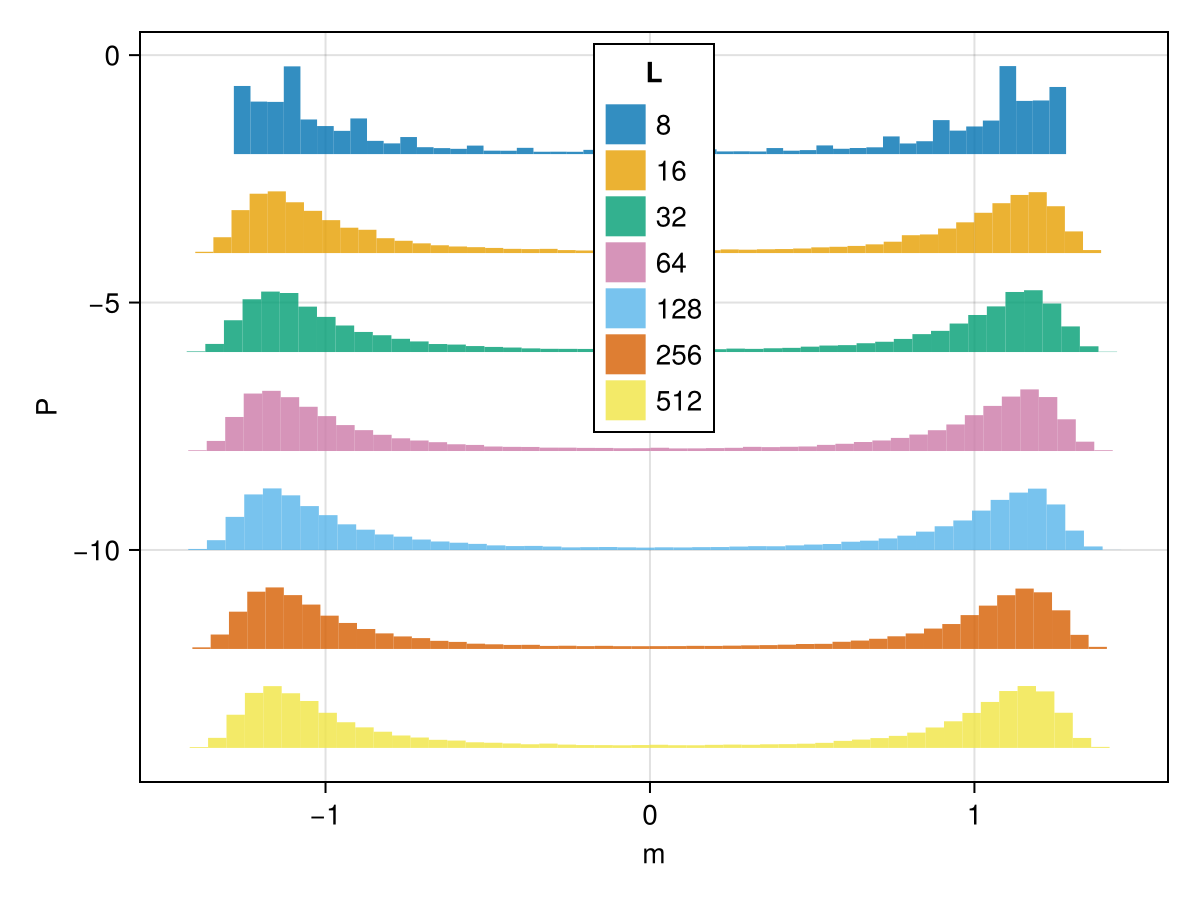

In [50]:
f=Figure()
ax=Axis(f[1,1],xlabel="m",ylabel="P")
for (j,L) in pairs(critdata["sizes"])
    hist!(critdata["maglists"][:,j]./critmags[j],
        bins=50,normalization=:pdf,label=string(L),
        offset=-2*j)
end
axislegend(ax,"L",position=:ct)
f

Finally lets extract the free energies

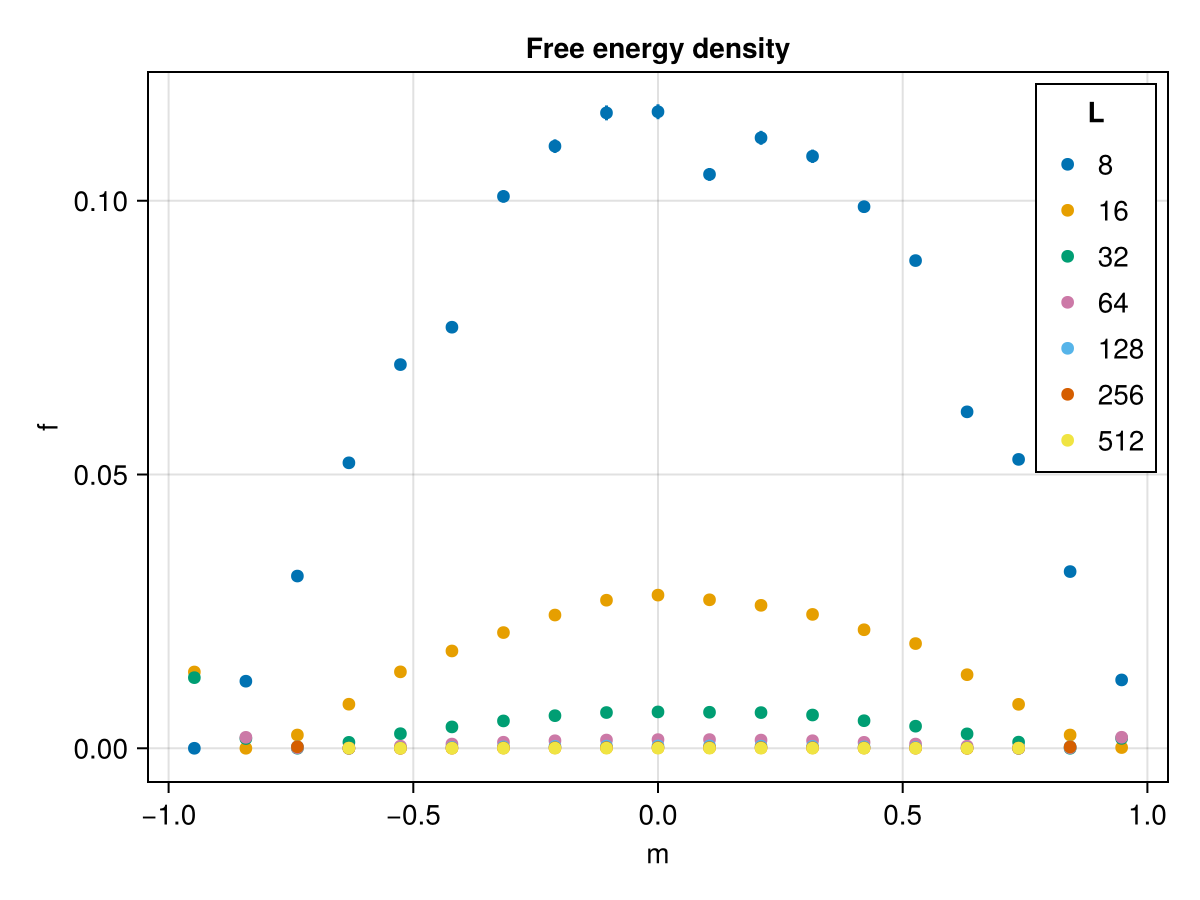

In [51]:
fig=Figure()
ax=Axis(fig[1,1],xlabel="m",ylabel="f",
    title="Free energy density")
for (j,L) in pairs(critdata["sizes"])
    x,f,df=freeenergy(critdata["maglists"][:,j],betac,
        L^2,-1,1,20)
    plot!(ax,x,f,label=string(L))
    errorbars!(ax,x,f,df)
end
axislegend(ax,"L",position=:rt)
fig

Lets change this from free energy density, to free energy,

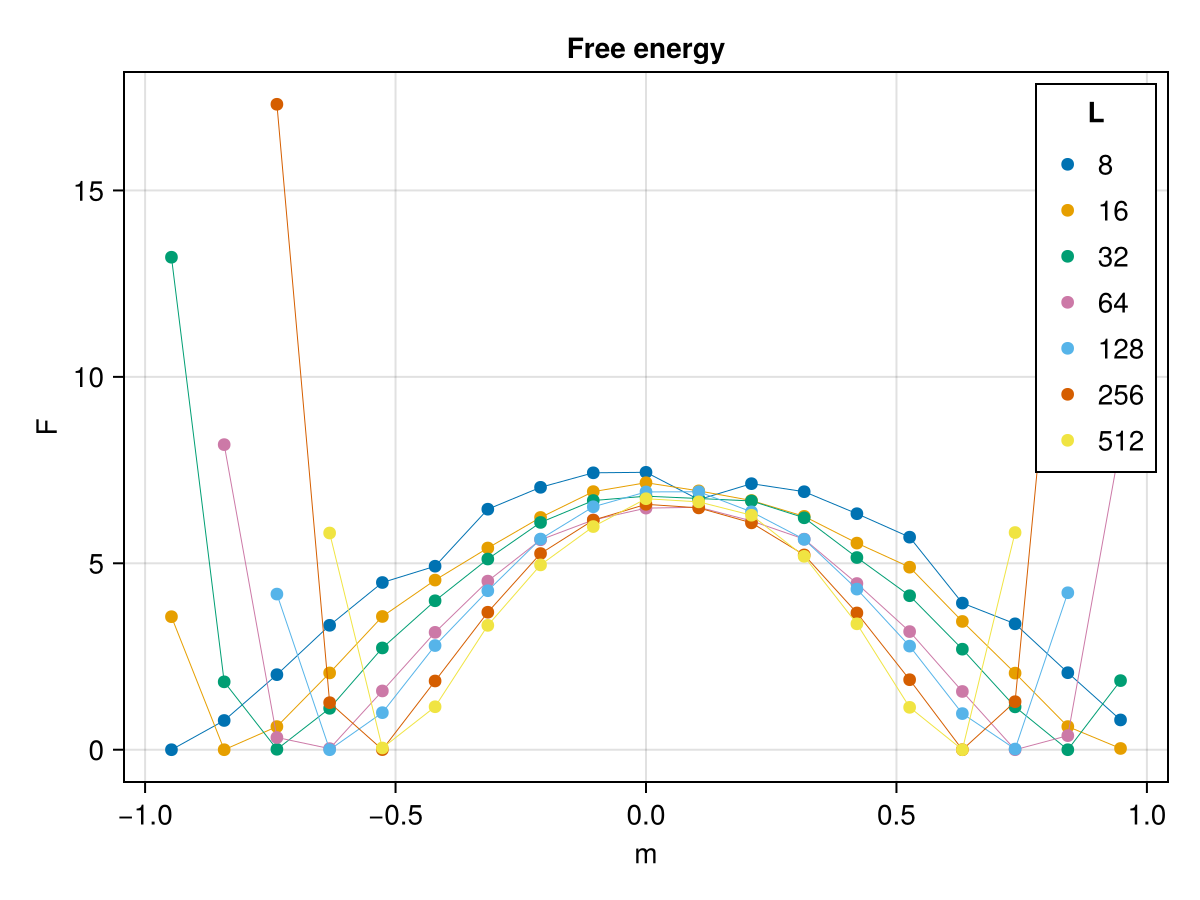

In [52]:
fig=Figure()
ax=Axis(fig[1,1],xlabel="m",ylabel="F",
    title="Free energy")
for (j,L) in pairs(critdata["sizes"])
    x,f,df=freeenergy(critdata["maglists"][:,j],betac,
        L^2,-1,1,20)
    plot!(ax,x,f*L^2,label=string(L))
    lines!(ax,x,f*L^2,linewidth=0.5)
    errorbars!(ax,x,f*L^2,df)
end
axislegend(ax,"L",position=:rt)
fig

Now lets rescale the x-axis

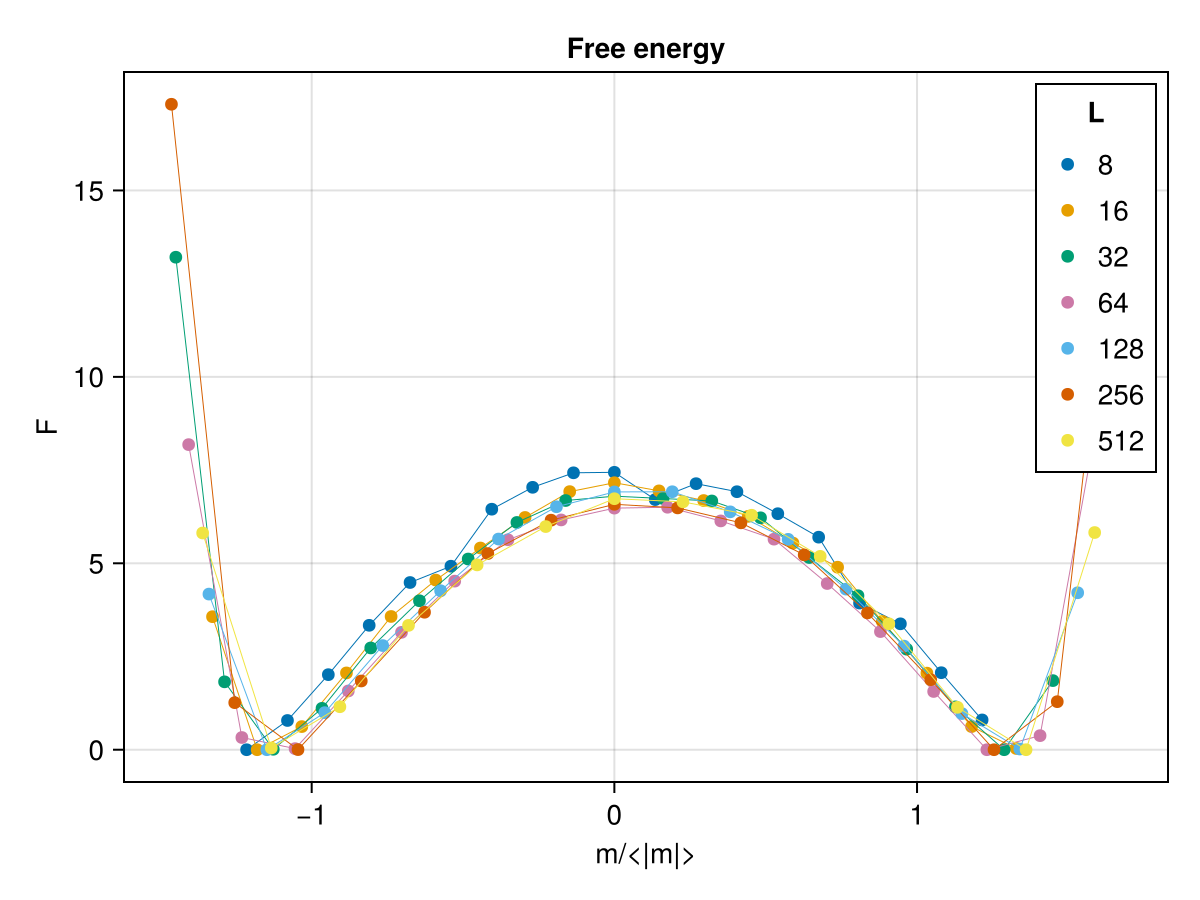

In [53]:
fig=Figure()
ax=Axis(fig[1,1],xlabel="m/<|m|>",ylabel="F",
    title="Free energy")
for (j,L) in pairs(critdata["sizes"])
    x,f,df=freeenergy(critdata["maglists"][:,j],betac,
        L^2,-1,1,20)
    plot!(ax,x/critmags[j],f*L^2,label=string(L))
    lines!(ax,x/critmags[j],f*L^2,linewidth=0.5)
    errorbars!(ax,x/critmags[j],f*L^2,df)
end
axislegend(ax,"L",position=:rt)
fig

## Scaling away from the critical point

We have empirically established that at the critical point, as $L\to\infty$ the Binder cumulant approaches a constant, and the magnetization scales as
\begin{equation}
\langle|m|\rangle_{\beta=\beta_c} \sim L^{-\delta},
\end{equation}
with $\delta\approx 1/8$.

Moving away from $\beta_c$, we know the spin patterns develop a finite correlation length, $\xi$.  One way to think about things is that on scales smaller than $\xi$ the system looks critical -- while on longer scales it looks paramagnetic/ferromagnetic.


Here is an example pattern

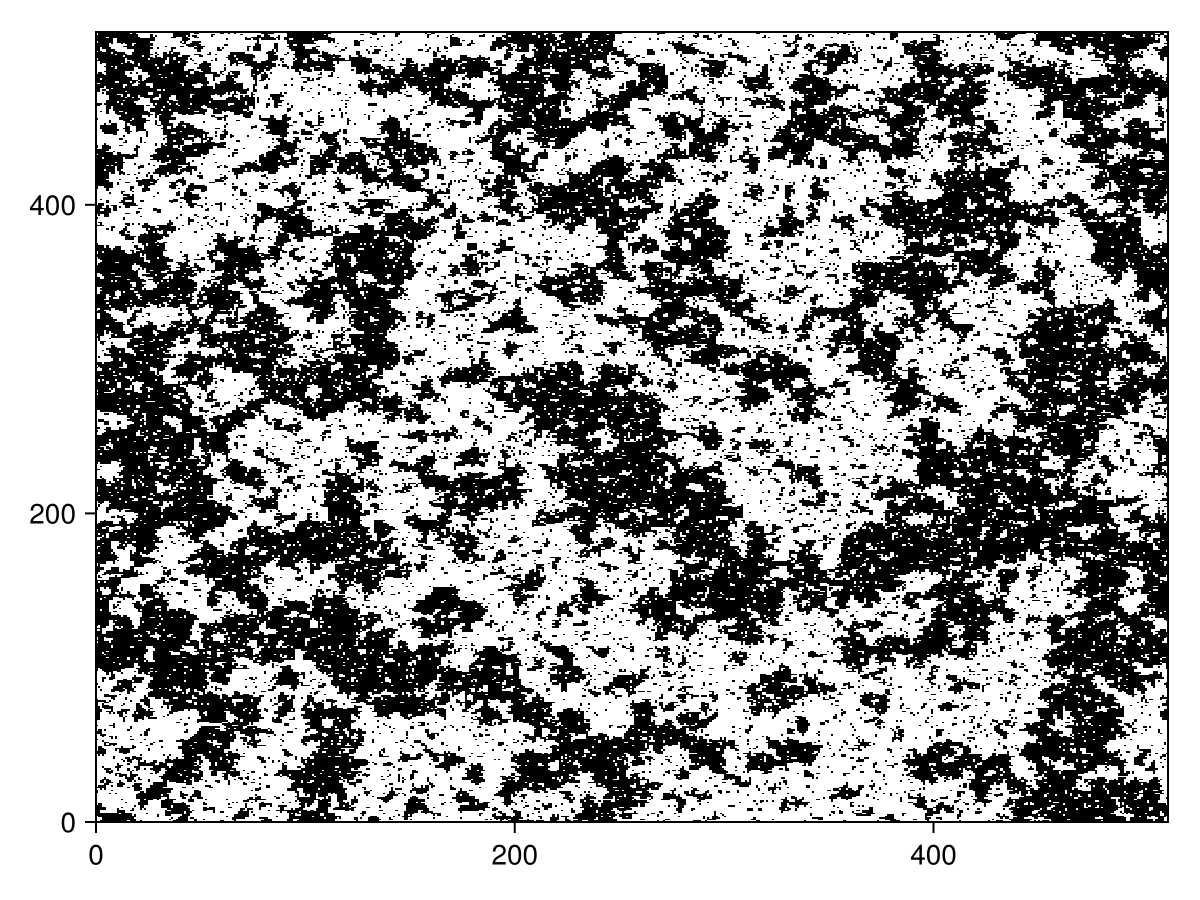

In [54]:
s=copy(cr["512"])
sim=fullsimulate!(s,betac-0.02,0.,10,1)
image(s,interpolate=false)

Clearly that pattern has a characteristi length of around 100 sites.  If we zoom in on a small piece though, it looks scale invariant

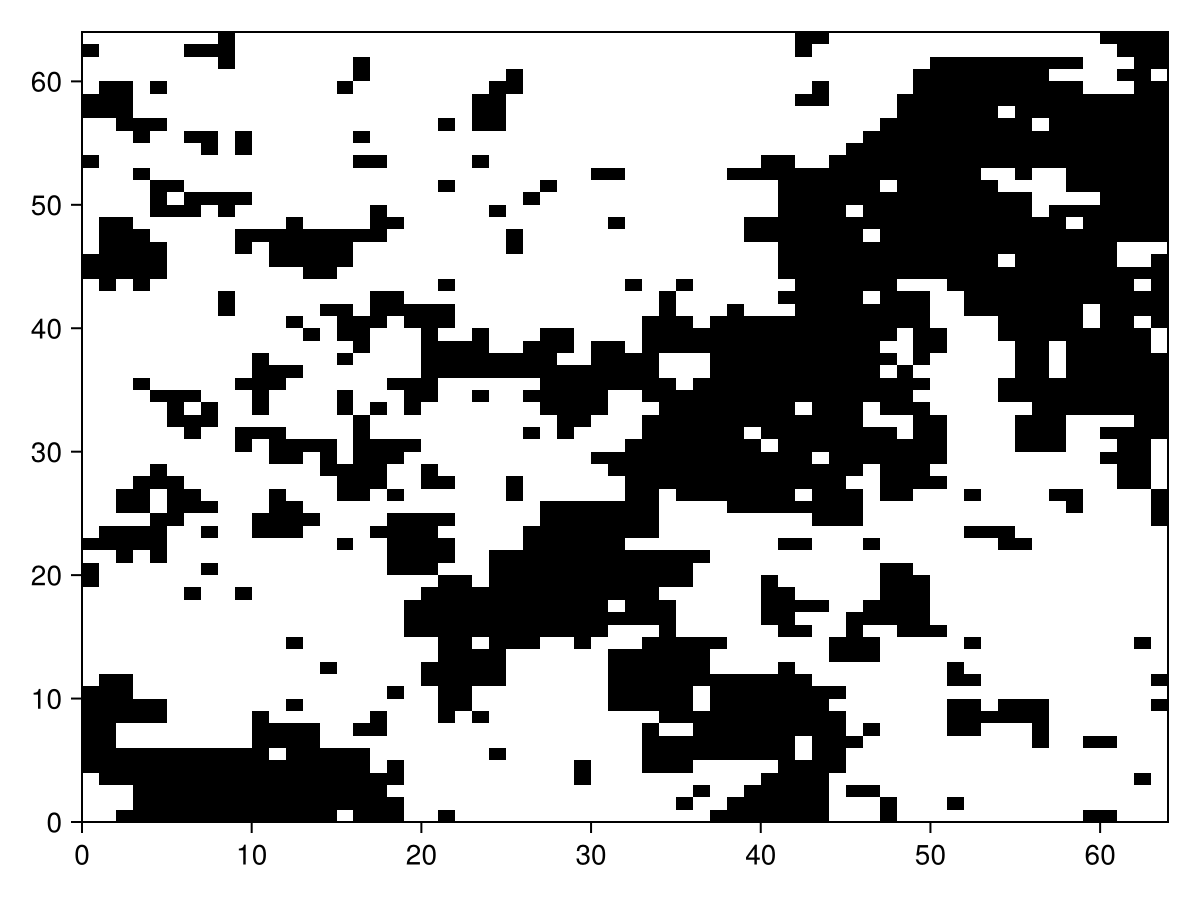

In [55]:
image(s[1:64,1:64],interpolate=false)

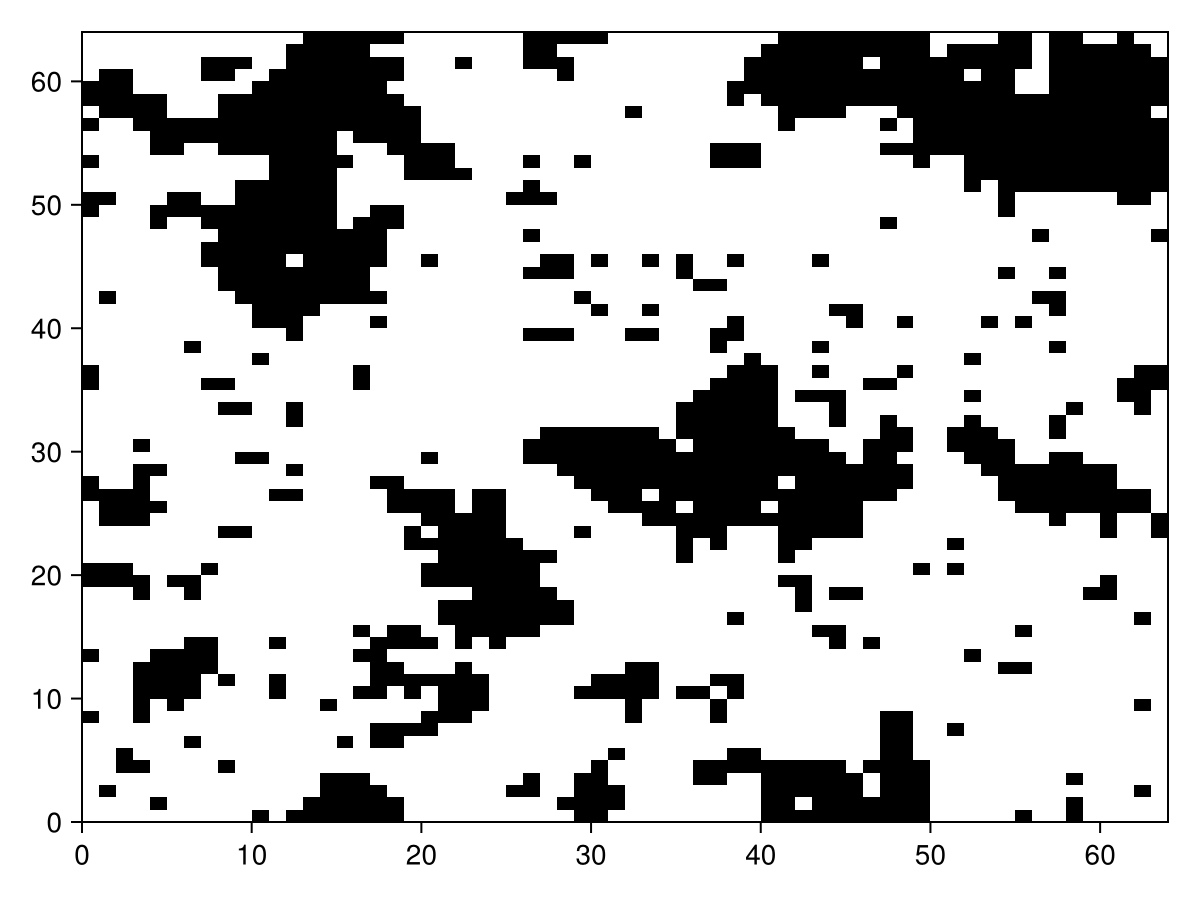

In [56]:
image(cr["64"],interpolate=false)

We will quantify that a little better in a future lecture.  Nonetheless, at finite $\beta-\beta_c$ there is a correlation length $\xi$, and patches smaller than $\xi$ are independent.  In a region small compared to $\xi$ the system looks critical.  Thus we expect

\begin{equation}
\langle |m|\rangle= L^{-\delta} w(L/\xi)
\end{equation}

Here $w(x)$ is a function for which $w(0)$ is a constant.

On the ferromagnetic side of resonance, as $L\to\infty$, the magnetization approaches a constant.  Therefore,
\begin{equation}
w(x)\sim x^{-\delta}
\end{equation}
as $x\to\infty$.

IE.  In the thermodynamic limit, near the critical point 
\begin{equation}
\langle |m|\rangle \sim \xi^{-\delta}.
\end{equation}
We will see this behavior whenever $L\gg \xi \gg 1$.

In a later lecture we will extract the correlation length from our data.  Since the correlation length diverges at the critical point we expect
\begin{equation}
\xi \sim |\beta-\beta_c|^{-\nu}
\end{equation}
and hence in the thermodynamic limit
\begin{align}
\langle |m|\rangle &\sim |\beta-\beta_c|^{\nu\delta}
&= |\beta-\beta_c|^\beta.
\end{align}
For the finite size system we instead expect
\begin{equation}
\langle |m|\rangle= L^{-\delta} w(L|\beta-\beta_c|^\nu).
\end{equation}
Since $w$ is well behaved as $\beta\to \beta_c$ (for finite $L$, the small $|\beta-\beta_c|$ expansion must be
\begin{equation}
\langle |m|\rangle\sim  c_1 L^{-\delta} +  c_2 L^{1/\nu-\delta}(\beta-\beta_c)+\cdots,
\end{equation}
where $c_1$ and $c_2$ are constants.
Thus we can extract $\nu$ from our data by looking at the $L$ dependence of $\partial \langle |m|\rangle/\partial \beta$ at $\beta_c$.


Just to make your head hurt harder, it turns out there is a better way to extract $\nu$.  That is from the $\beta$ dependence of the Binder cumulant.  The same argument about the scaling of $\langle |m|\rangle$ says that near the phase transition the binder cumulant should have the scaling form
\begin{align}
b=b_c+ c_3 L^{1/\nu} (\beta-\beta_c)+\cdots
\end{align}
Thus if we find the slope $\partial b/\partial \beta$ at $\beta_c$, it should be a power law in the system size.

Recall, here was our data for the Binder cumulants:

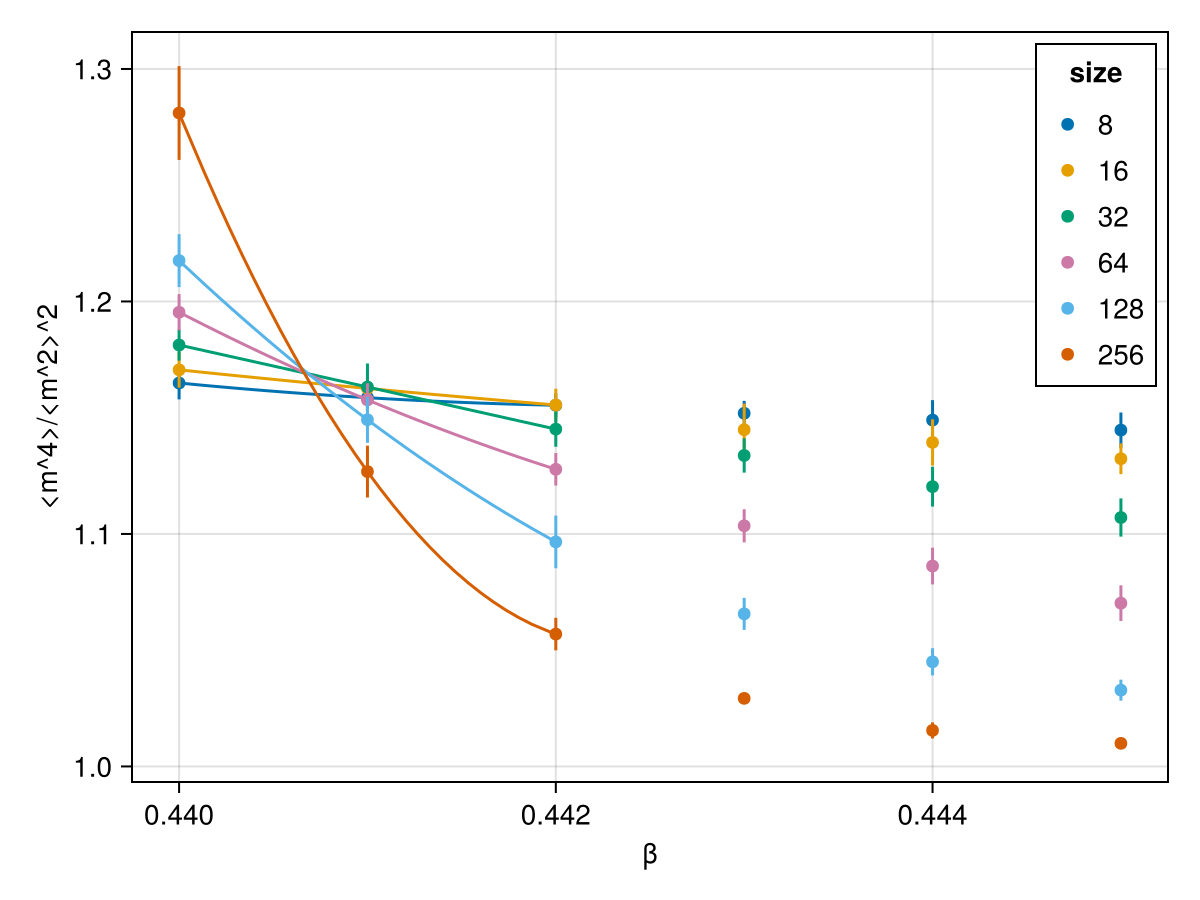

In [57]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="<m^4>/<m^2>^2")
for size_index in 1:length(hhrdata)
    plot!(betas,bdat[size_index,:],label=string(sizes[size_index]))
    lines!(betas[1]..betas[3],x->fits[size_index](x))
    errorbars!(betas,bdat[size_index,:],ebdat[size_index,:])
end
axislegend(ax,"size", position = :rt)
f

The polynomials package that we are using knows how to take derivatives:

In [58]:
dbdbeta=[derivative(f)(betac) for f in fits]

6-element Vector{Float64}:
   -5.740516045335115
   -7.820250736195289
  -18.067257841054325
  -36.22297736638874
  -65.47086291362073
 -138.47965660007992

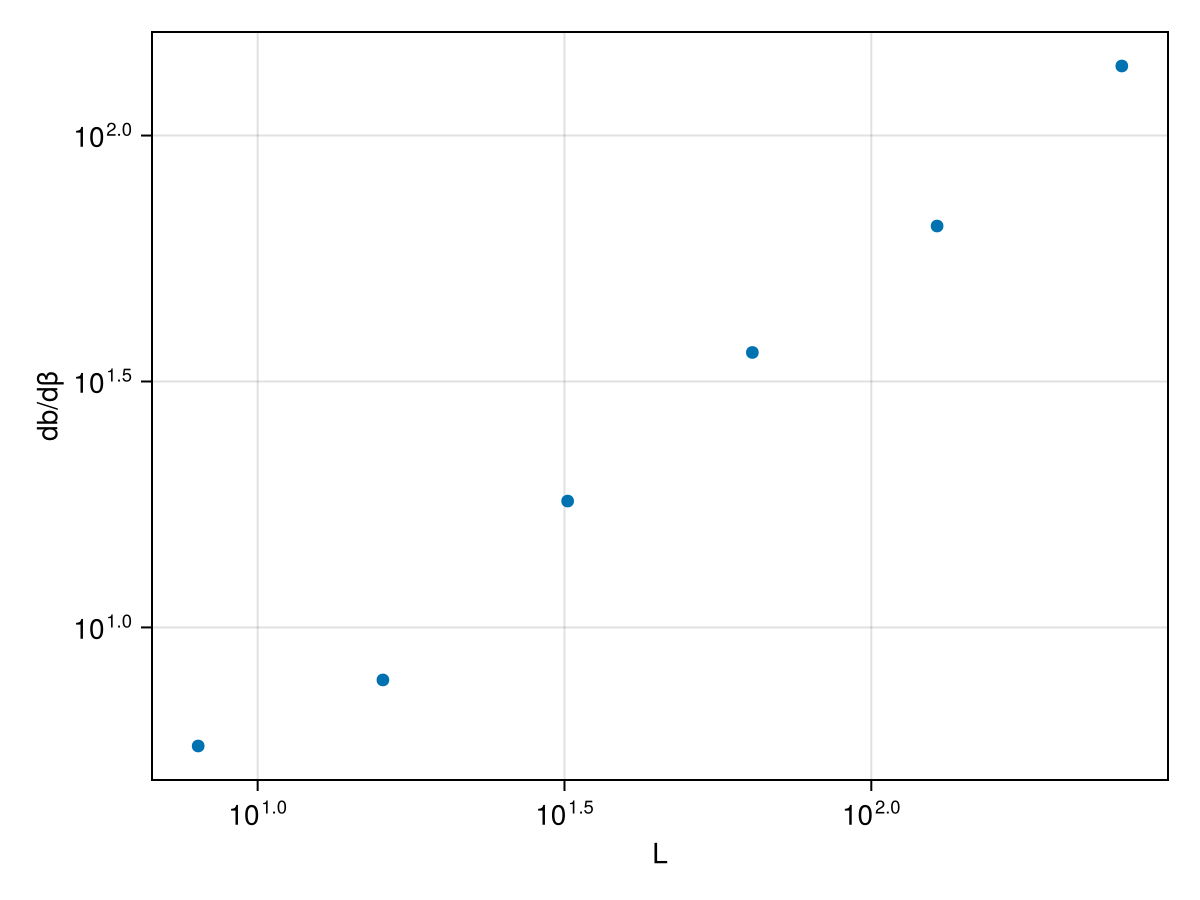

In [59]:
p=plot(sizes,-dbdbeta)
p.axis.xlabel="L"
p.axis.ylabel="db/dβ"
p.axis.xscale=log10
p.axis.yscale=log10
p

In [63]:
f2=linearfit(log.(sizes[2:end]),log.(-dbdbeta[2:end]),(x->1.,x->x))

2-element Vector{Float64}:
 -0.6907424445265872
  1.0150106191127928

So if we plot the binder cumulant vs $(\beta-\beta_c)*L$, the data should collapse:

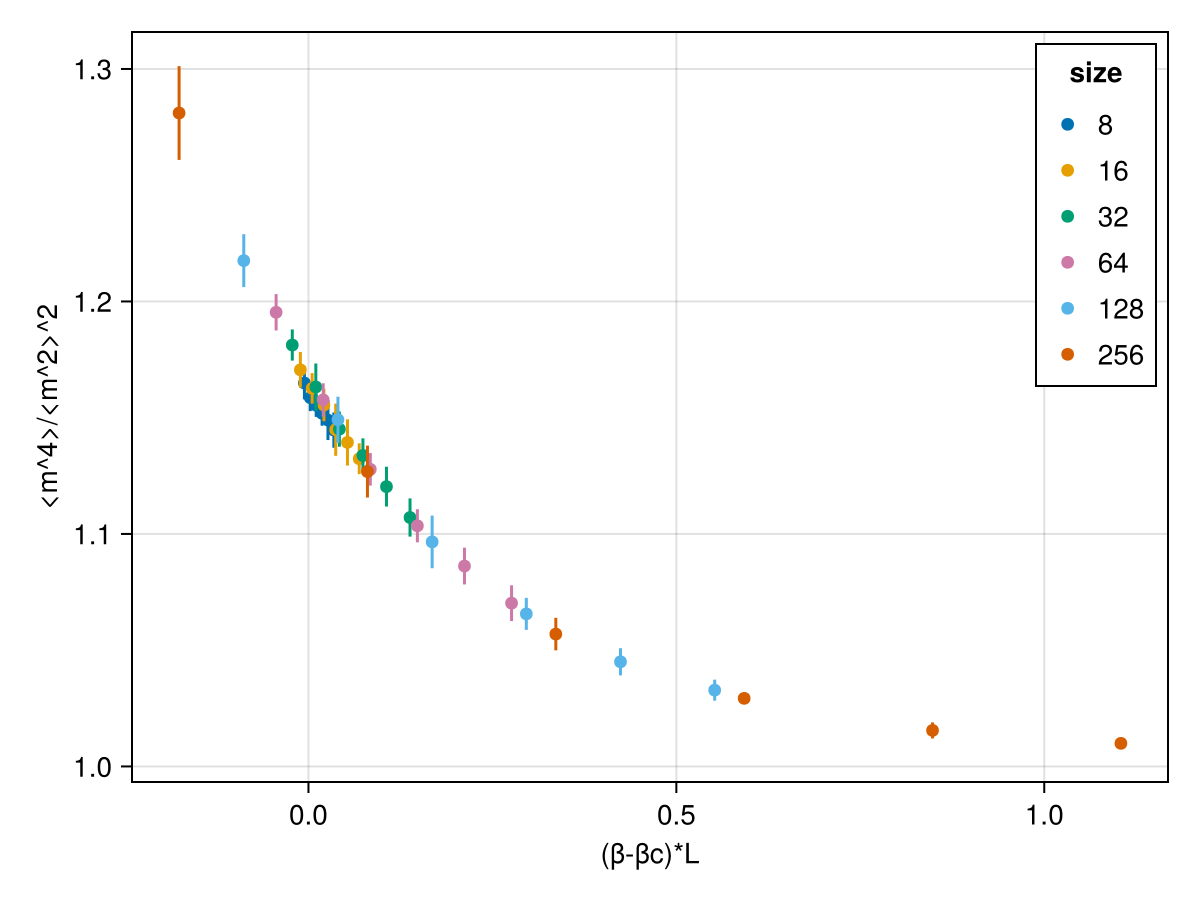

In [64]:
f=Figure()
ax=Axis(f[1,1],xlabel="(β-βc)*L",ylabel="<m^4>/<m^2>^2")
for size_index in 1:length(hhrdata)
    L=sizes[size_index]
    plot!((betas.-betac).*L,bdat[size_index,:],label=string(sizes[size_index]))
    errorbars!((betas.-betac).*L,bdat[size_index,:],ebdat[size_index,:])
end
axislegend(ax,"size", position = :rt)
f

The same scaling should work for the magnetization.  Recall this was the magnetization vs $\beta$

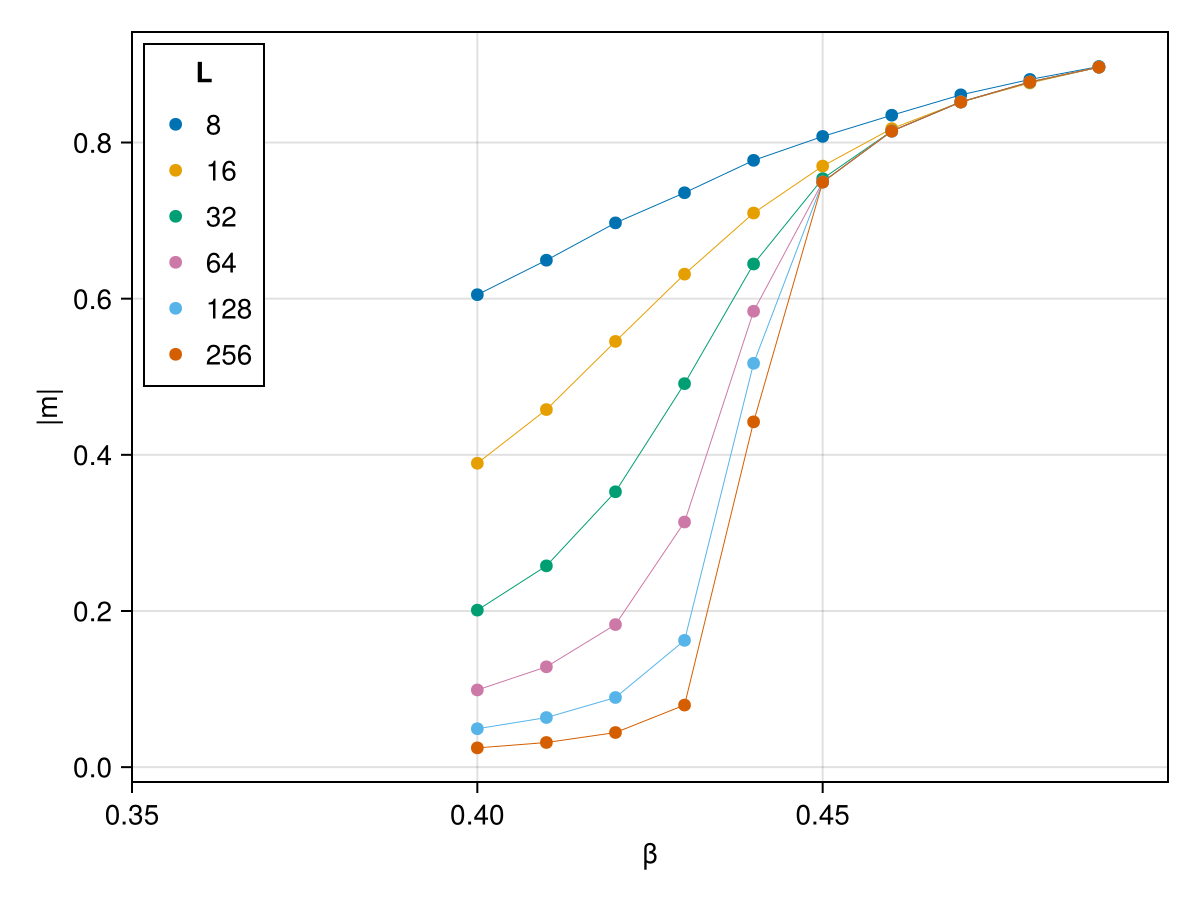

In [65]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="|m|")
for set in hrdata
    betas=[set.betas...]
    ave_error=stats(set,:maglists,x->abs.(x))
    ave=[m[1] for m in ave_error]
    err=[m[2] for m in ave_error]
    plot!(ax,betas,ave,label=string(set.arraysize[1]))
    errorbars!(ax,betas,ave,err)
    lines!(ax,betas,ave,linewidth=0.5)
end
axislegend("L", position = :lt)
xlims!(ax,0.35,0.5)
f

We now scale the vertical axis by $L^{1/8}$ and the horizontal axis by $L$, we get

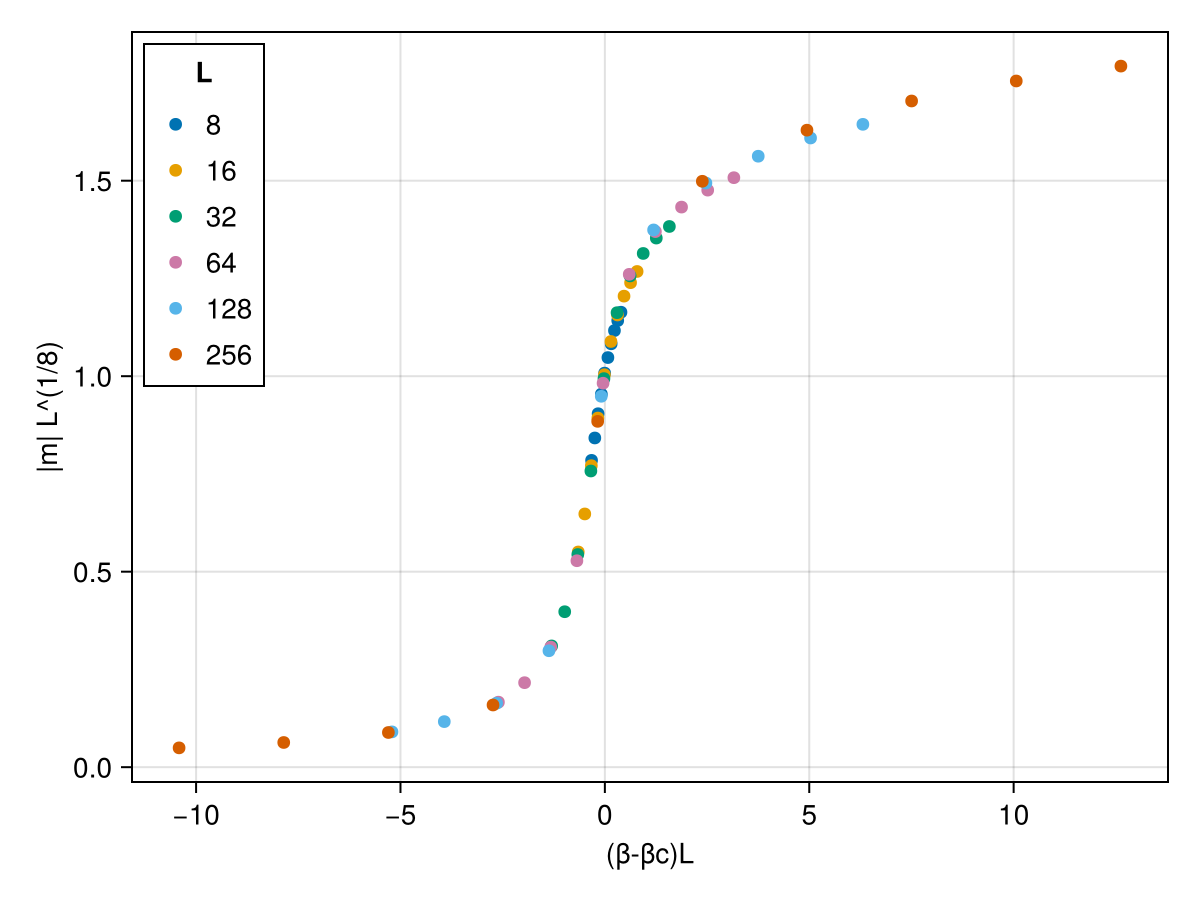

In [66]:
f=Figure()
ax=Axis(f[1,1],xlabel="(β-βc)L",ylabel="|m| L^(1/8)")
for set in hrdata
    L=set.arraysize[1]
    betas=[set.betas...]
    ave_error=stats(set,:maglists,x->abs.(x))
    ave=[m[1] for m in ave_error]
    err=[m[2] for m in ave_error]
    plot!(ax,(betas.-betac)*L,ave*L^(1/8),label=string(set.arraysize[1]))
    errorbars!(ax,(betas.-betac)*L,ave*L^(1/8),err*L^(1/8))
end
axislegend("L", position = :lt)
f

This scaling is truly remarkable.  It only, however, occurs near Tc.  If we take the more widely spaced data:

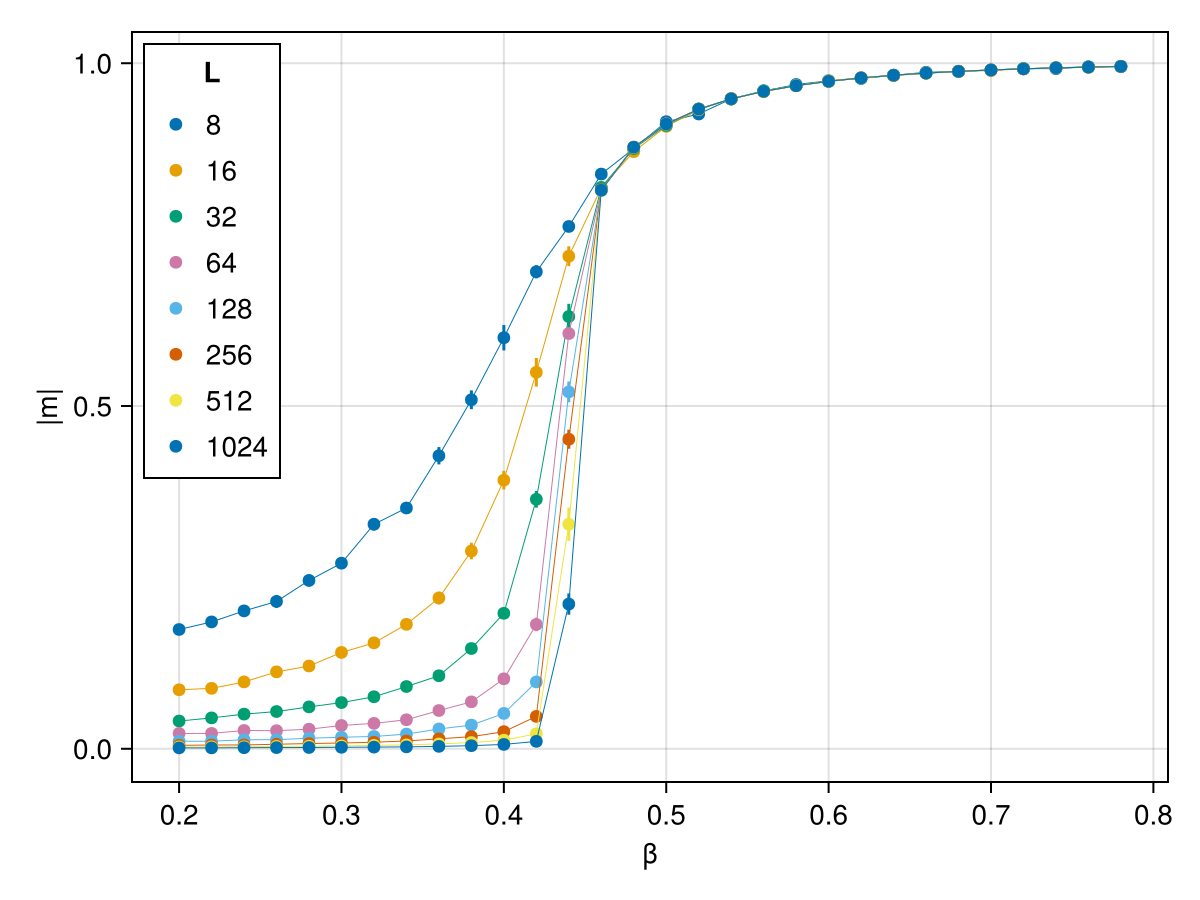

In [67]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="|m|")
for set in data
    betas=[set.betas...]
    ave_error=stats(set,:maglists,x->abs.(x))
    ave=[m[1] for m in ave_error]
    err=[m[2] for m in ave_error]
    plot!(ax,betas,ave,label=string(set.arraysize[1]))
    errorbars!(ax,betas,ave,err)
    lines!(ax,betas,ave,linewidth=0.5)
end
axislegend("L", position = :lt)
f

The collapse then only occurs over part of the data:

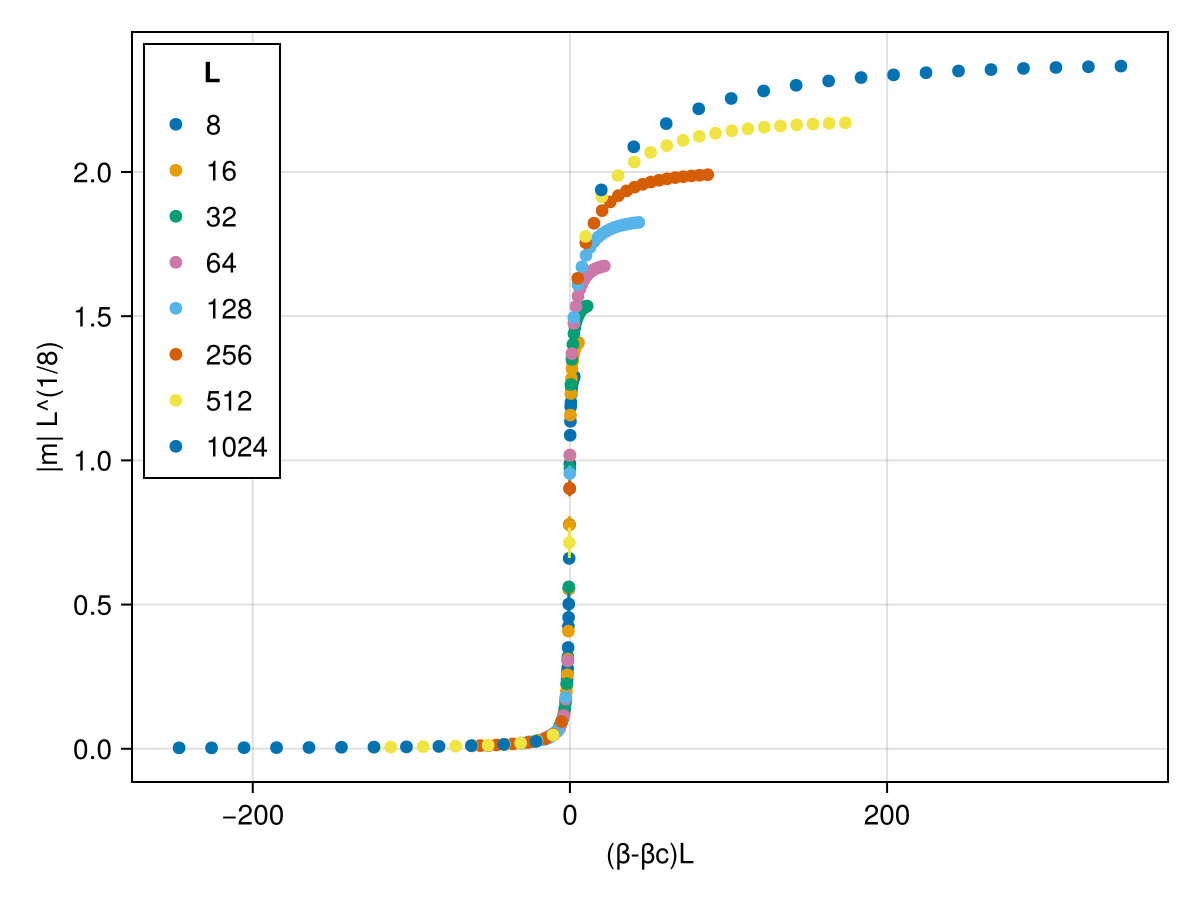

In [68]:
f=Figure()
ax=Axis(f[1,1],xlabel="(β-βc)L",ylabel="|m| L^(1/8)")
for set in data
    L=set.arraysize[1]
    betas=[set.betas...]
    ave_error=stats(set,:maglists,x->abs.(x))
    ave=[m[1] for m in ave_error]
    err=[m[2] for m in ave_error]
    plot!(ax,(betas.-betac)*L,ave*L^(1/8),label=string(set.arraysize[1]))
    errorbars!(ax,(betas.-betac)*L,ave*L^(1/8),err*L^(1/8))
end
axislegend("L", position = :lt)
f

Regardless, this sort of data collapse is one of the most remarkable features of phase transitions.

To reitterate: This data collapse indicates system has a characteristic scale $\xi$ -- and aside from a scale factor, all physical quantities only depend on the ratio $L/\xi$.

Probably the most common way to conceptualize this feature is through the renormalization group -- which we will discuss in the next notebook.